In [ ]:
# ============================================================
# CELL 0 — Setup (Colab)
# ============================================================
import re, os, math, random
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.signal import stft, butter, sosfilt, resample_poly

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)


Device: cpu


In [ ]:
# ============================================================
# CELL 1 — Paths + escolha de banda e receptor
# ============================================================
ROOT = Path("/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC")

# RX
RX_DIRS = {
    "LF": ROOT / "RX_LF",
    "MF": ROOT / "RX_MF",
    "HF": ROOT / "RX_HF",
}

# TX (wav + csv)
TX_WAV_DIRS = {
    "LF": ROOT / "TX_WAVEFORMS/TX/wav/LF",
    "MF": ROOT / "TX_WAVEFORMS/TX/wav/MF",
    "HF": ROOT / "TX_WAVEFORMS/TX/wav/HF",
}
TX_CSV_DIRS = {
    "LF": ROOT / "TX_WAVEFORMS/TX/csv/LF",
    "MF": ROOT / "TX_WAVEFORMS/TX/csv/MF",
    "HF": ROOT / "TX_WAVEFORMS/TX/csv/HF",
}

# CTD (opcional para esta pipeline; não é obrigatório aqui)
CTD_PATH = ROOT / "ENVIRONMENT/Environmental/CTD.csv"

BAND = "LF"     # "LF" / "MF" / "HF"
RX_NODE = "R1"  # "R1" / "R2"

assert RX_DIRS[BAND].exists(), RX_DIRS[BAND]
assert TX_WAV_DIRS[BAND].exists(), TX_WAV_DIRS[BAND]
assert TX_CSV_DIRS[BAND].exists(), TX_CSV_DIRS[BAND]

print("OK.")
print("BAND:", BAND, "| RX:", RX_NODE)
print("RX root:", RX_DIRS[BAND])
print("TX wav :", TX_WAV_DIRS[BAND])
print("TX csv :", TX_CSV_DIRS[BAND])
print("CTD exists?", CTD_PATH.exists())


OK.
BAND: LF | RX: R1
RX root: /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/RX_LF
TX wav : /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/TX_WAVEFORMS/TX/wav/LF
TX csv : /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/TX_WAVEFORMS/TX/csv/LF
CTD exists? True


In [ ]:
# ============================================================
# CELL 2 — Utils (áudio, STFT, modulação)
# ============================================================

BANDS = {
    "LF": (2500.0, 9500.0),
    "MF": (7000.0, 16500.0),
    "HF": (18000.0, 36000.0),
}

def bandpass_sos(fs, f1, f2, order=6):
    nyq = 0.5 * fs
    f1n = max(1.0, f1) / nyq
    f2n = min(nyq - 1.0, f2) / nyq
    return butter(order, [f1n, f2n], btype="bandpass", output="sos")

def preprocess_audio(x, fs, band=BAND, target_fs=48000):
    x = x.astype(np.float32)
    f1, f2 = BANDS[band]
    sos = bandpass_sos(fs, f1, f2, order=6)
    x = sosfilt(sos, x)

    if fs != target_fs:
        g = np.gcd(int(fs), int(target_fs))
        up = target_fs // g
        down = fs // g
        x = resample_poly(x, up, down).astype(np.float32)
        fs = target_fs

    x = x - np.median(x)
    x = x / (np.median(np.abs(x)) + 1e-9)
    return x, fs

def normalized_xcorr_peak(rx, tx):
    r = np.correlate(rx, tx, mode="valid")
    denom = np.linalg.norm(tx) * np.linalg.norm(rx[:len(tx)]) + 1e-9
    peak = float(np.max(np.abs(r)) / denom)
    lag = int(np.argmax(np.abs(r)))
    return peak, lag

def make_spec(x, fs, nperseg=1024, noverlap=768):
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
    P = np.log10(np.abs(Z)**2 + 1e-12).astype(np.float32)
    med = np.median(P)
    mad = np.median(np.abs(P - med)) + 1e-9
    Pn = (P - med) / mad
    return torch.from_numpy(Pn).unsqueeze(0)  # (1,F,T)

def modulation_from_name(name: str):
    s = str(name).upper()
    if "OFDM" in s: return "OFDM"
    if "OSDM" in s or "OTFS" in s: return "OSDM/OTFS"
    if "JANUS" in s: return "JANUS"
    if "MFSK" in s: return "MFSK"
    if "SC-QPSK" in s or "QPSK" in s: return "QPSK"
    if "S2C" in s: return "S2C-QPSK"
    if "FH-BCSK" in s: return "FH-BCSK"
    if "BCSK" in s: return "BCSK"
    if "PRBS" in s: return "PRBS"
    if "LFM"  in s: return "LFM"
    if "MULTITONE" in s: return "MULTITONE"
    if "BFGN" in s: return "BFGN"
    return "OTHER"

def cycle_from_name(name: str):
    m = re.search(r"cycle(\d+)", name.lower())
    return int(m.group(1)) if m else None


In [ ]:
# ============================================================
# CELL 3 — Bitstream CSV reader (robusto)
# ============================================================

def read_bitstream_csv(csv_path: Path):
    """
    Tenta ler diferentes formatos:
    - uma coluna com 0/1 ou ±1
    - várias colunas numéricas (flatten)
    - delimitadores variados
    Retorna np.ndarray float32 (valores em {0,1} ou {-1,+1}), ou None se não der.
    """
    # tenta separadores comuns
    seps = [",", ";", "\t", " "]
    for sep in seps:
        try:
            df = pd.read_csv(csv_path, header=None, sep=sep, engine="python")
            arr = df.values
            # tenta converter tudo para float
            flat = []
            for v in arr.reshape(-1):
                try:
                    flat.append(float(v))
                except Exception:
                    pass
            if len(flat) == 0:
                continue
            x = np.array(flat, dtype=np.float32)

            # normaliza para {0,1} ou {-1,+1}
            # se for 0/1 -> mantém
            uniq = np.unique(np.round(x))
            if set(uniq.tolist()).issubset({0.0, 1.0}):
                return np.round(x).astype(np.float32)

            # se for ±1 -> mantém
            if set(uniq.tolist()).issubset({-1.0, 1.0}):
                return np.round(x).astype(np.float32)

            # se for qualquer coisa (p.ex. QAM symbols), não é bitstream "puro"
            return None
        except Exception:
            continue
    return None

def stem_key(p: Path):
    # chave “aproximada” para casar wav/csv
    # remove sufixos comuns tipo "-b" e variações
    s = p.stem
    s = re.sub(r"[-_]?b$", "", s, flags=re.IGNORECASE)  # remove ...-b
    return s.upper()


In [ ]:
# ============================================================
# CELL 4 — TX bank (wav + bitstream quando existir)
# ============================================================

tx_wavs = sorted(TX_WAV_DIRS[BAND].glob("*.wav"))
tx_csvs = sorted(TX_CSV_DIRS[BAND].glob("*.csv"))

assert len(tx_wavs) > 0, "No TX wavs found"
print("TX wav files:", len(tx_wavs))
print("TX csv files:", len(tx_csvs))

# index por chave aproximada
wav_by_key = {stem_key(p): p for p in tx_wavs}
csv_by_key = {stem_key(p): p for p in tx_csvs}

TX_BANK = []
for k, wavp in wav_by_key.items():
    x, fs0 = sf.read(wavp)
    x, fs = preprocess_audio(x, fs0, band=BAND, target_fs=48000)

    # limita duração p/ acelerar matching
    max_s = 16.0
    if len(x) > int(max_s * fs):
        x = x[:int(max_s * fs)]

    csvp = csv_by_key.get(k, None)
    bit = read_bitstream_csv(csvp) if csvp is not None else None

    TX_BANK.append({
        "key": k,
        "tx_wav": wavp.name,
        "wav_path": wavp,
        "x": x,
        "fs": fs,
        "modulation": modulation_from_name(wavp.name),
        "csv_path": str(csvp) if csvp is not None else None,
        "bitstream": bit
    })

df_tx = pd.DataFrame([{
    "key": t["key"],
    "tx_wav": t["tx_wav"],
    "modulation": t["modulation"],
    "has_bitstream": t["bitstream"] is not None,
    "csv_path": t["csv_path"]
} for t in TX_BANK])

display(df_tx.sort_values(["has_bitstream","modulation"], ascending=[False, True]).head(20))
print("Bitstream-available TX:", int(df_tx["has_bitstream"].sum()), "/", len(df_tx))
print(df_tx[df_tx["has_bitstream"]]["modulation"].value_counts())


TX wav files: 16
TX csv files: 8


,key,tx_wav,modulation,has_bitstream,csv_path
2,BCSK-LF,BCSK-LF.wav,BCSK,True,/content/drive/MyDrive/SFI SMART OCEAN DATASET...
4,FH-BCSK-LF,FH-BCSK-LF.wav,FH-BCSK,True,/content/drive/MyDrive/SFI SMART OCEAN DATASET...
14,P-PRBS-LF,P-PRBS-LF.wav,PRBS,True,/content/drive/MyDrive/SFI SMART OCEAN DATASET...
5,JANUS-LF,JANUS-LF.wav,JANUS,False,None
10,MFSK-LF,MFSK-LF.wav,MFSK,False,None
12,OFDM-LF,OFDM-LF.wav,OFDM,False,/content/drive/MyDrive/SFI SMART OCEAN DATASET...
13,OSDM-LF,OSDM-LF.wav,OSDM/OTFS,False,/content/drive/MyDrive/SFI SMART OCEAN DATASET...
3,BFGN-LF,BFGN-LF.wav,OTHER,False,None
6,LFM-225-LF,LFM-225-LF.wav,OTHER,False,None
7,LFM-25-LF,LFM-25-LF.wav,OTHER,False,None


Bitstream-available TX: 3 / 16
modulation
BCSK       1
FH-BCSK    1
PRBS       1
Name: count, dtype: int64


In [ ]:
# ============================================================
# CELL 5 — RX list + matching (weak labels)
# ============================================================

rx_files = sorted(RX_DIRS[BAND].rglob(f"{BAND}_{RX_NODE}_cycle*.wav"))
rx_files = [p for p in rx_files if cycle_from_name(p.name) is not None]
assert len(rx_files) > 0, "No RX cycles found"

print("RX cycles:", len(rx_files))

# mapa por ciclo
wav_map = {cycle_from_name(p.name): p for p in rx_files}

CROP_S = 20.0   # acelera matching
matches = []

for cyc, rxp in tqdm(sorted(wav_map.items()), desc=f"RX→TX matching ({BAND}/{RX_NODE})", unit="cycle"):
    rx, fs0 = sf.read(rxp)
    if len(rx) > int(CROP_S * fs0):
        rx = rx[:int(CROP_S * fs0)]
    rx, fs = preprocess_audio(rx, fs0, band=BAND, target_fs=48000)

    best = None
    for tx in TX_BANK:
        if tx["fs"] != fs:
            continue
        peak, lag = normalized_xcorr_peak(rx, tx["x"])
        if best is None or peak > best["peak"]:
            best = {
                "cycle": int(cyc),
                "rx_file": rxp.name,
                "tx_wav": tx["tx_wav"],
                "tx_key": tx["key"],
                "modulation": tx["modulation"],
                "peak": float(peak),
                "lag_s": float(lag / fs),
                "has_bitstream": tx["bitstream"] is not None,
            }
    matches.append(best)

df_match = pd.DataFrame(matches).sort_values("cycle").reset_index(drop=True)
display(df_match.head())

plt.figure(figsize=(7,3))
plt.hist(df_match["peak"].values, bins=30)
plt.title("Matching confidence (normalized xcorr peak)")
plt.xlabel("peak correlation (proxy)")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Weak-label modulation counts:")
print(df_match["modulation"].value_counts())


RX cycles: 80


RX→TX matching (LF/R1):   0%|          | 0/80 [00:00<?, ?cycle/s]

KeyboardInterrupt: 

## celula 5 com salvamento

Saving matches to: /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/MATCHES

Processing BAND=LF | RX=R1
RX cycles found: 80


RX→TX matching (LF/R1): 100%|██████████| 80/80 [11:38:31<00:00, 523.90s/cycle]

Saved CSV → LF_R1_matches.csv


,band,rx_node,cycle,rx_file,tx_wav,tx_key,modulation,peak,lag_s,has_bitstream
0,LF,R1,1,LF_R1_cycle01.wav,JANUS-LF.wav,JANUS-LF,JANUS,2.908382,7.302604,False
1,LF,R1,2,LF_R1_cycle02.wav,JANUS-LF.wav,JANUS-LF,JANUS,3.067775,6.894833,False
2,LF,R1,3,LF_R1_cycle03.wav,JANUS-LF.wav,JANUS-LF,JANUS,2.447819,10.271062,False
3,LF,R1,4,LF_R1_cycle04.wav,JANUS-LF.wav,JANUS-LF,JANUS,2.248506,8.472917,False
4,LF,R1,5,LF_R1_cycle05.wav,JANUS-LF.wav,JANUS-LF,JANUS,2.573718,13.560896,False


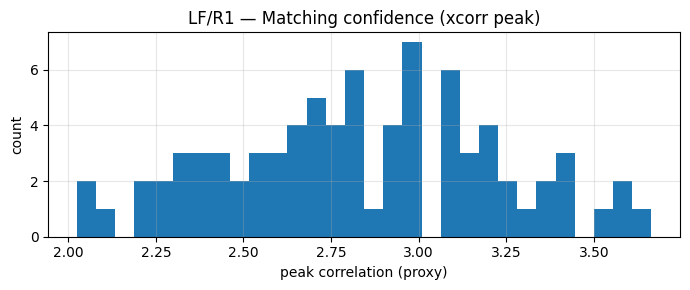

Weak-label modulation counts:
modulation
JANUS    80
Name: count, dtype: int64

Processing BAND=MF | RX=R1
RX cycles found: 80


RX→TX matching (MF/R1):  96%|█████████▋| 77/80 [11:13:44<26:24, 528.20s/cycle]

In [ ]:
# ============================================================
# CELL ÚNICA — RX→TX matching (LF, MF, HF) + save results
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

# ----------------------------
# CONFIG
# ----------------------------
ROOT = Path("/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC")

RX_DIRS = {
    "LF": ROOT / "RX_LF",
    "MF": ROOT / "RX_MF",
    "HF": ROOT / "RX_HF",
}

OUT_DIR = ROOT / "MATCHES"
OUT_DIR.mkdir(parents=True, exist_ok=True)

RX_NODE = "R1"          # "R1" ou "R2"
BANDS_SEQ = ["LF", "MF", "HF"]

CROP_S = 20.0           # acelera matching
TARGET_FS = 48000

print("Saving matches to:", OUT_DIR.resolve())

# ----------------------------
# LOOP POR BANDA
# ----------------------------
for BAND in BANDS_SEQ:

    print("\n" + "="*70)
    print(f"Processing BAND={BAND} | RX={RX_NODE}")
    print("="*70)

    # --------------------------------------------------------
    # RX list por ciclo (igual ao seu CELL 5)
    # --------------------------------------------------------
    rx_files = sorted(RX_DIRS[BAND].rglob(f"{BAND}_{RX_NODE}_cycle*.wav"))
    rx_files = [p for p in rx_files if cycle_from_name(p.name) is not None]

    assert len(rx_files) > 0, f"No RX cycles found for {BAND}/{RX_NODE}"

    print("RX cycles found:", len(rx_files))

    wav_map = {cycle_from_name(p.name): p for p in rx_files}

    # --------------------------------------------------------
    # Matching RX → TX (weak labels)
    # --------------------------------------------------------
    matches = []

    for cyc, rxp in tqdm(
        sorted(wav_map.items()),
        desc=f"RX→TX matching ({BAND}/{RX_NODE})",
        unit="cycle"
    ):
        rx, fs0 = sf.read(rxp)

        if rx.ndim == 2:
            rx = rx[:, 0]

        if len(rx) > int(CROP_S * fs0):
            rx = rx[:int(CROP_S * fs0)]

        rx, fs = preprocess_audio(
            rx, fs0, band=BAND, target_fs=TARGET_FS
        )

        best = None

        for tx in TX_BANK:
            if tx["fs"] != fs:
                continue

            peak, lag = normalized_xcorr_peak(rx, tx["x"])

            if best is None or peak > best["peak"]:
                best = {
                    "band": BAND,
                    "rx_node": RX_NODE,
                    "cycle": int(cyc),
                    "rx_file": rxp.name,
                    "tx_wav": tx["tx_wav"],
                    "tx_key": tx["key"],
                    "modulation": tx["modulation"],
                    "peak": float(peak),
                    "lag_s": float(lag / fs),
                    "has_bitstream": tx["bitstream"] is not None,
                }

        matches.append(best)

    # --------------------------------------------------------
    # DataFrame + save CSV
    # --------------------------------------------------------
    df_match = (
        pd.DataFrame(matches)
        .sort_values("cycle")
        .reset_index(drop=True)
    )

    out_csv = OUT_DIR / f"{BAND}_{RX_NODE}_matches.csv"
    df_match.to_csv(out_csv, index=False)

    print(f"Saved CSV → {out_csv.name}")
    display(df_match.head())

    # --------------------------------------------------------
    # Histogram (matching confidence)
    # --------------------------------------------------------
    plt.figure(figsize=(7, 3))
    plt.hist(df_match["peak"].values, bins=30)
    plt.title(f"{BAND}/{RX_NODE} — Matching confidence (xcorr peak)")
    plt.xlabel("peak correlation (proxy)")
    plt.ylabel("count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    out_png = OUT_DIR / f"{BAND}_{RX_NODE}_hist.png"
    plt.savefig(out_png, dpi=200)
    plt.show()

    print("Weak-label modulation counts:")
    print(df_match["modulation"].value_counts())

print("\n RX→TX matching concluído para LF, MF e HF.")
print(" Results in:", OUT_DIR.resolve())


## graficos

In [ ]:
# ============================================================
# SELEÇÃO DE RX WAVs A PARTIR DO MATCHING (Cell 5)
# ============================================================

TAU = 0.25   # limiar de confiança (ajuste olhando o histograma)

df_sel = df_match[df_match["peak"] >= TAU].copy()
assert len(df_sel) > 0, "df_sel vazio — diminua TAU"

print("RX WAVs selecionados:", len(df_sel))
print("Por modulação:")
print(df_sel["modulation"].value_counts())

# Caminhos completos dos RX WAVs
RX_ROOT = RX_DIRS[BAND]
rx_paths = [next(RX_ROOT.rglob(p)) for p in df_sel["rx_file"].values]

print("Exemplo de arquivos RX usados:")
for p in rx_paths[:5]:
    print(" ", p)


In [ ]:
# ============================================================
# CELL 6 — Physics-Guided LUPI dataset
# Privileged info = TX + Channel descriptors (training only)
# ============================================================

# ---------
# 6.1 Funções auxiliares para descritores privilegiados
# ---------
from scipy.signal import hilbert
from scipy.stats import kurtosis

def estimate_cfo(rx, tx, fs, fmax=80, step=5):
    """CFO bruto via busca em correlação complexa"""
    rx_c = hilbert(rx).astype(np.complex64)
    tx_c = hilbert(tx).astype(np.complex64)
    N = min(len(rx_c), len(tx_c))
    t = np.arange(N)/fs
    best_f, best_score = 0.0, -1.0
    for f in np.arange(-fmax, fmax+1e-6, step):
        rot = np.exp(-1j*2*np.pi*f*t)
        score = np.abs(np.vdot(rx_c[:N], tx_c[:N]*rot))
        if score > best_score:
            best_score, best_f = score, f
    return best_f

def channel_descriptors(rx, tx, fs, lag):
    """Extrai descritores físicos do canal"""
    # Alinhamento
    end = lag + len(tx)
    if end > len(rx):
        rx_seg = rx[lag:]
    else:
        rx_seg = rx[lag:end]

    env = np.abs(hilbert(rx_seg))
    env /= (env.max() + 1e-9)

    # Delay spread RMS
    p = env**2
    p /= (p.sum() + 1e-12)
    tau = np.arange(len(p)) / fs
    mu = np.sum(tau * p)
    ds_rms = np.sqrt(np.sum((tau - mu)**2 * p))

    # Tail energy (reverberação)
    tail_50ms = np.sum(p[int(0.05*fs):]) if len(p) > int(0.05*fs) else 0.0

    return {
        "ds_rms": float(ds_rms),
        "tail_50ms": float(tail_50ms),
        "env_kurtosis": float(kurtosis(env, fisher=False))
    }


In [ ]:
# ============================================================
# CELL 7 — Build LUPI dataframe with privileged descriptors
# ============================================================

rows = []

for _, r in tqdm(df_match.iterrows(), total=len(df_match), desc="Building LUPI table"):
    rxp = wav_map[int(r["cycle"])]
    tx  = next(t for t in TX_BANK if t["tx_wav"] == r["tx_wav"])

    # RX preprocess
    rx, fs0 = sf.read(rxp)
    rx, fs = preprocess_audio(rx, fs0, band=BAND)

    # TX
    tx_x = tx["x"]

    # Channel match
    peak, lag = r["peak"], int(r["lag_s"] * fs)
    cfo = estimate_cfo(rx, tx_x, fs)

    desc = channel_descriptors(rx, tx_x, fs, lag)

    rows.append({
        "cycle": r["cycle"],
        "rx_file": r["rx_file"],
        "modulation": r["modulation"],
        "peak": peak,
        "cfo": cfo,
        **desc
    })

df_lupi = pd.DataFrame(rows)

display(df_lupi.head())
print("\nClass balance:")
print(df_lupi["modulation"].value_counts())


Building LUPI table:   0%|          | 0/80 [00:00<?, ?it/s]

,cycle,rx_file,modulation,peak,cfo,ds_rms,tail_50ms,env_kurtosis
0,1,LF_R1_cycle01.wav,JANUS,2.908382,20.0,0.644437,0.971478,3.251648
1,2,LF_R1_cycle02.wav,JANUS,3.067775,30.0,0.640817,0.979916,3.260781
2,3,LF_R1_cycle03.wav,JANUS,2.447819,40.0,0.633281,0.974914,3.134453
3,4,LF_R1_cycle04.wav,JANUS,2.248506,70.0,0.637470,0.979779,3.275702
4,5,LF_R1_cycle05.wav,JANUS,2.573718,-50.0,0.636279,0.977964,3.257185



Class balance:
modulation
JANUS    80
Name: count, dtype: int64


NaNs per column:
peak            0
cfo             0
ds_rms          0
tail_50ms       0
env_kurtosis    0
dtype: int64

Descriptor summary:


,count,mean,std,min,25%,50%,75%,max
peak,80.0,2.830278,0.383987,2.024589,2.551796,2.819111,3.102686,3.663581
cfo,80.0,-8.562500,51.962677,-80.000000,-60.000000,-7.500000,40.000000,80.000000
ds_rms,80.0,0.268712,0.161481,0.184574,0.196644,0.199192,0.201526,0.644437
tail_50ms,80.0,0.995776,0.008962,0.969947,0.999992,0.999994,0.999996,0.999997
env_kurtosis,80.0,4.800591,0.697617,3.125809,4.848853,5.065934,5.187289,5.484179


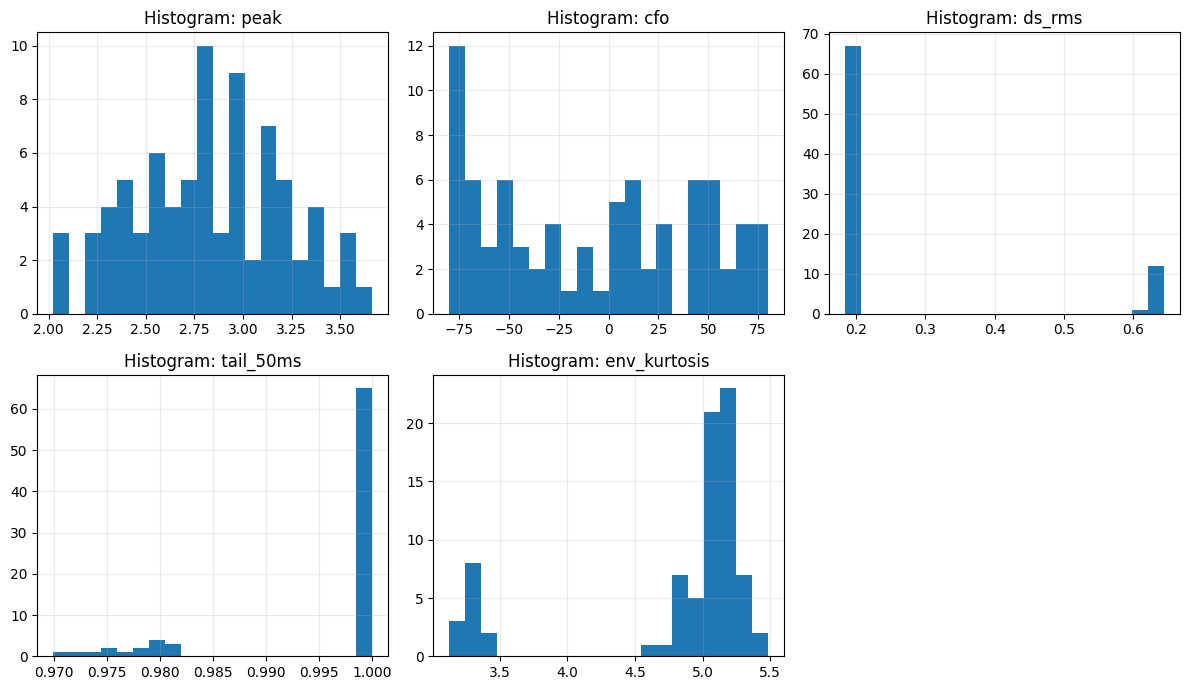

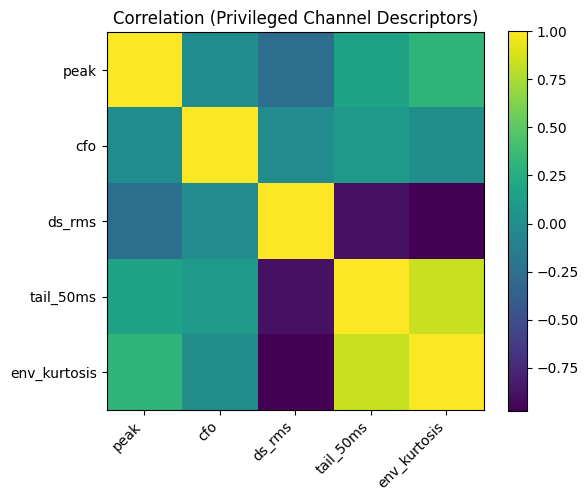

In [ ]:
# ============================================================
# CELL 8 — Sanitize df_lupi + EDA (ENGLISH PLOTS)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "df_lupi" in globals() and len(df_lupi) > 0

PRIV_COLS = ["peak", "cfo", "ds_rms", "tail_50ms", "env_kurtosis"]

# force numeric
for c in PRIV_COLS:
    df_lupi[c] = pd.to_numeric(df_lupi[c], errors="coerce")

print("NaNs per column:")
print(df_lupi[PRIV_COLS].isna().sum())

# simple imputation (physically safe)
df_lupi["cfo"]  = df_lupi["cfo"].fillna(0.0)
df_lupi["peak"] = df_lupi["peak"].fillna(0.0)
for c in ["ds_rms", "tail_50ms", "env_kurtosis"]:
    df_lupi[c] = df_lupi[c].fillna(df_lupi[c].median())

df_lupi[PRIV_COLS] = df_lupi[PRIV_COLS].astype(np.float32)

print("\nDescriptor summary:")
display(df_lupi[PRIV_COLS].describe().T)

# Histograms
fig = plt.figure(figsize=(12,7))
for i, c in enumerate(PRIV_COLS, 1):
    plt.subplot(2,3,i)
    plt.hist(df_lupi[c].values, bins=20)
    plt.title(f"Histogram: {c}")
    plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Correlation heatmap (no seaborn)
corr = df_lupi[PRIV_COLS].corr().values
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(PRIV_COLS)), PRIV_COLS, rotation=45, ha="right")
plt.yticks(range(len(PRIV_COLS)), PRIV_COLS)
plt.title("Correlation (Privileged Channel Descriptors)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# CELL 9 — Dataset for regression: RX spectrogram -> y_priv
# ============================================================

import torch
from torch.utils.data import Dataset, DataLoader

assert "wav_map" in globals()
assert "make_spec" in globals()
assert "preprocess_audio" in globals()
assert "BAND" in globals()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

# normalize targets (important for stable regression)
Y_MEAN = df_lupi[PRIV_COLS].mean().values.astype(np.float32)
Y_STD  = (df_lupi[PRIV_COLS].std().values.astype(np.float32) + 1e-6)

def norm_y(y):
    return (y - Y_MEAN) / Y_STD

def denorm_y(yn):
    return yn * Y_STD + Y_MEAN

class Spec2DescDataset(Dataset):
    def __init__(self, df, crop_s=3.0):
        self.df = df.reset_index(drop=True)
        self.crop_s = float(crop_s)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        rxp = wav_map[int(r["cycle"])]

        x, fs0 = sf.read(rxp)
        x, fs  = preprocess_audio(x, fs0, band=BAND)

        win = int(self.crop_s * fs)
        if len(x) > win:
            s = np.random.randint(0, len(x)-win+1)
            x = x[s:s+win]

        Xspec = make_spec(x, fs)  # (1,F,T)
        y = r[PRIV_COLS].values.astype(np.float32)
        y = norm_y(y).astype(np.float32)
        return Xspec, torch.from_numpy(y)

# split
idx = np.arange(len(df_lupi))
rng = np.random.default_rng(42)
rng.shuffle(idx)
n = len(idx)
tr = idx[:int(0.7*n)]
va = idx[int(0.7*n):int(0.85*n)]
te = idx[int(0.85*n):]

ds_tr = Spec2DescDataset(df_lupi.iloc[tr], crop_s=3.0)
ds_va = Spec2DescDataset(df_lupi.iloc[va], crop_s=3.0)
ds_te = Spec2DescDataset(df_lupi.iloc[te], crop_s=3.0)

dl_tr = DataLoader(ds_tr, batch_size=8, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=8, shuffle=False, num_workers=0)
dl_te = DataLoader(ds_te, batch_size=8, shuffle=False, num_workers=0)

print("Split sizes | train/val/test:", len(ds_tr), len(ds_va), len(ds_te))
print("Target mean/std:", Y_MEAN, Y_STD)


device: cpu
Split sizes | train/val/test: 56 12 12
Target mean/std: [ 2.830278   -8.5625      0.26871198  0.99577636  4.8005915 ] [3.8398784e-01 5.1962677e+01 1.6148171e-01 8.9625865e-03 6.9761801e-01]


In [ ]:
# ============================================================
# CELL 10 — Baseline: Spectrogram CNN -> descriptor regression
# ============================================================

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

class SpecRegressorCNN(nn.Module):
    def __init__(self, out_dim=5):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        z = self.backbone(x).flatten(1)
        return self.head(z)

model = SpecRegressorCNN(out_dim=len(PRIV_COLS)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

best = 1e9
best_state = None

EPOCHS = 25

for ep in range(EPOCHS):
    model.train()
    tr_loss = 0.0
    for X, y in dl_tr:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        yp = model(X)
        loss = loss_fn(yp, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tr_loss += float(loss.item()) * len(X)

    # val
    model.eval()
    va_loss = 0.0
    ys, yps = [], []
    with torch.no_grad():
        for X, y in dl_va:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            yp = model(X)
            va_loss += float(loss_fn(yp, y).item()) * len(X)
            ys.append(y.cpu().numpy())
            yps.append(yp.cpu().numpy())

    tr_loss /= max(1, len(ds_tr))
    va_loss /= max(1, len(ds_va))

    ys = np.concatenate(ys, axis=0)
    yps = np.concatenate(yps, axis=0)

    # MAE in original units
    ys_u  = denorm_y(ys)
    yps_u = denorm_y(yps)
    mae = mean_absolute_error(ys_u, yps_u)

    print(f"Epoch {ep+1:02d} | train loss {tr_loss:.4f} | val loss {va_loss:.4f} | val MAE {mae:.4f}")

    if va_loss < best:
        best = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest val loss:", best)


Epoch 01 | train loss 0.3924 | val loss 0.4133 | val MAE 8.4040
Epoch 02 | train loss 0.3893 | val loss 0.4133 | val MAE 8.4644
Epoch 03 | train loss 0.3872 | val loss 0.4160 | val MAE 8.5102
Epoch 04 | train loss 0.3859 | val loss 0.4167 | val MAE 8.5028
Epoch 05 | train loss 0.3867 | val loss 0.4187 | val MAE 8.5255
Epoch 06 | train loss 0.3857 | val loss 0.4182 | val MAE 8.5839
Epoch 07 | train loss 0.3856 | val loss 0.4203 | val MAE 8.6716


KeyboardInterrupt: 

In [ ]:
# ============================================================
# CELL 10.1 — Sanity baseline: predict median of train (per descriptor)
# ============================================================

from sklearn.metrics import mean_absolute_error

# Recover split indices from CELL 9 (tr/va/te). If not present, abort.
assert "tr" in globals() and "va" in globals() and "te" in globals()

Y_tr = df_lupi.iloc[tr][PRIV_COLS].values.astype(np.float32)
Y_va = df_lupi.iloc[va][PRIV_COLS].values.astype(np.float32)

median_pred = np.median(Y_tr, axis=0, keepdims=True).repeat(len(Y_va), axis=0)

print("Median-baseline MAE per descriptor (VAL):")
for j, name in enumerate(PRIV_COLS):
    mae = mean_absolute_error(Y_va[:, j], median_pred[:, j])
    print(f" - {name:12s}: MAE={mae:.4f}")


Median-baseline MAE per descriptor (VAL):
 - peak        : MAE=0.4317
 - cfo         : MAE=42.0833
 - ds_rms      : MAE=0.0737
 - tail_50ms   : MAE=0.0035
 - env_kurtosis: MAE=0.4362


In [ ]:
# ============================================================
# CELL 10.2 — Better regression head: uncertainty-weighted multi-task loss
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class SpecRegressorCNN_UW(nn.Module):
    def __init__(self, out_dim=5):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, out_dim)
        )
        # learned log variances (one per task)
        self.log_sigma2 = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):
        z = self.backbone(x).flatten(1)
        y = self.head(z)
        return y

def uw_loss(y_pred, y_true, log_sigma2):
    """
    Kendall & Gal multi-task uncertainty weighting (regression)
    Loss = sum( exp(-s_i)*|e_i| + s_i )  with s_i = log sigma^2
    Use SmoothL1 per dimension.
    """
    e = F.smooth_l1_loss(y_pred, y_true, reduction="none")  # (B, D)
    precision = torch.exp(-log_sigma2).unsqueeze(0)         # (1, D)
    loss = (precision * e + log_sigma2.unsqueeze(0)).mean()
    return loss

model = SpecRegressorCNN_UW(out_dim=len(PRIV_COLS)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best = 1e9
best_state = None
EPOCHS = 40

for ep in range(EPOCHS):
    model.train()
    tr_loss = 0.0
    for X, y in dl_tr:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        yp = model(X)
        loss = uw_loss(yp, y, model.log_sigma2)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()

        tr_loss += float(loss.item()) * len(X)

    model.eval()
    va_loss = 0.0
    ys, yps = [], []
    with torch.no_grad():
        for X, y in dl_va:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            yp = model(X)
            loss = uw_loss(yp, y, model.log_sigma2)
            va_loss += float(loss.item()) * len(X)
            ys.append(y.cpu().numpy())
            yps.append(yp.cpu().numpy())

    tr_loss /= max(1, len(ds_tr))
    va_loss /= max(1, len(ds_va))

    print(f"Epoch {ep+1:02d} | train {tr_loss:.4f} | val {va_loss:.4f} | log_sigma2={model.log_sigma2.detach().cpu().numpy()}")

    if va_loss < best:
        best = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest val loss:", best)


Epoch 01 | train 0.4007 | val 0.4176 | log_sigma2=[-0.00692165 -0.00690124 -0.00664849 -0.00638464 -0.00667741]
Epoch 02 | train 0.3881 | val 0.4166 | log_sigma2=[-0.01383669 -0.01377748 -0.01303522 -0.01255032 -0.01311109]
Epoch 03 | train 0.3836 | val 0.4140 | log_sigma2=[-0.02070583 -0.0206934  -0.01983055 -0.01923441 -0.01992166]
Epoch 04 | train 0.3747 | val 0.4077 | log_sigma2=[-0.02742705 -0.02729626 -0.0262334  -0.02560432 -0.02628861]
Epoch 05 | train 0.3693 | val 0.4037 | log_sigma2=[-0.03436218 -0.0340012  -0.03253918 -0.03187723 -0.03258216]
Epoch 06 | train 0.3620 | val 0.3995 | log_sigma2=[-0.04120575 -0.04084441 -0.03896787 -0.03822625 -0.03898918]
Epoch 07 | train 0.3642 | val 0.3958 | log_sigma2=[-0.04810826 -0.04745789 -0.04541343 -0.04454618 -0.04544799]
Epoch 08 | train 0.3566 | val 0.3945 | log_sigma2=[-0.05485799 -0.05424152 -0.05220098 -0.05124441 -0.05226196]
Epoch 09 | train 0.3514 | val 0.3891 | log_sigma2=[-0.06143945 -0.0609636  -0.05876482 -0.05763388 -0.05

In [ ]:
# ============================================================
# CELL 10.3 — Cycle-level aggregation: K crops per cycle
# ============================================================

class Spec2DescCycleDataset(Dataset):
    def __init__(self, df, crop_s=3.0, K=8):
        self.df = df.reset_index(drop=True)
        self.crop_s = float(crop_s)
        self.K = int(K)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        rxp = wav_map[int(r["cycle"])]

        x, fs0 = sf.read(rxp)
        x, fs = preprocess_audio(x, fs0, band=BAND)
        win = int(self.crop_s * fs)

        specs = []
        for _ in range(self.K):
            if len(x) > win:
                s = np.random.randint(0, len(x)-win+1)
                xw = x[s:s+win]
            else:
                xw = x
            specs.append(make_spec(xw, fs))   # (1,F,T)

        X = torch.stack(specs, dim=0)  # (K,1,F,T)

        y = r[PRIV_COLS].values.astype(np.float32)
        y = norm_y(y).astype(np.float32)
        return X, torch.from_numpy(y)

# rebuild loaders on cycle-level samples (each row = one cycle)
ds_trK = Spec2DescCycleDataset(df_lupi.iloc[tr], crop_s=3.0, K=8)
ds_vaK = Spec2DescCycleDataset(df_lupi.iloc[va], crop_s=3.0, K=8)
dl_trK = DataLoader(ds_trK, batch_size=4, shuffle=True, num_workers=0)
dl_vaK = DataLoader(ds_vaK, batch_size=4, shuffle=False, num_workers=0)

class SpecRegressorCNN_Agg(nn.Module):
    def __init__(self, out_dim=5):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, out_dim))

    def encode(self, x):
        return self.backbone(x).flatten(1)   # (B,64)

    def forward(self, Xk):
        # Xk: (B,K,1,F,T)
        B, K = Xk.shape[0], Xk.shape[1]
        X = Xk.view(B*K, *Xk.shape[2:]).contiguous()
        z = self.encode(X).view(B, K, -1).mean(dim=1)  # average over K
        return self.head(z)

modelK = SpecRegressorCNN_Agg(out_dim=len(PRIV_COLS)).to(DEVICE)
opt = torch.optim.Adam(modelK.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss()

best = 1e9
best_state = None
EPOCHS = 30

for ep in range(EPOCHS):
    modelK.train()
    tr_loss = 0.0
    for Xk, y in dl_trK:
        Xk = Xk.to(DEVICE)
        y  = y.to(DEVICE)
        yp = modelK(Xk)
        loss = loss_fn(yp, y)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(modelK.parameters(), 2.0)
        opt.step()

        tr_loss += float(loss.item()) * len(Xk)

    modelK.eval()
    va_loss = 0.0
    with torch.no_grad():
        for Xk, y in dl_vaK:
            yp = modelK(Xk.to(DEVICE))
            va_loss += float(loss_fn(yp, y.to(DEVICE)).item()) * len(Xk)

    tr_loss /= max(1, len(ds_trK))
    va_loss /= max(1, len(ds_vaK))
    print(f"Epoch {ep+1:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

    if va_loss < best:
        best = va_loss
        best_state = {k: v.detach().cpu().clone() for k,v in modelK.state_dict().items()}

if best_state is not None:
    modelK.load_state_dict(best_state)

print("\nBest val loss:", best)


Epoch 01 | train 0.3971 | val 0.4206
Epoch 02 | train 0.3895 | val 0.4187


KeyboardInterrupt: 

In [ ]:
# ============================================================
# CELL 10.4 — Evaluate on TEST set (cycle-level)
# ============================================================

from sklearn.metrics import mean_absolute_error

# build test dataset with same K aggregation
ds_teK = Spec2DescCycleDataset(df_lupi.iloc[te], crop_s=3.0, K=8)
dl_teK = DataLoader(ds_teK, batch_size=4, shuffle=False, num_workers=0)

modelK.eval()

ys, yps = [], []

with torch.no_grad():
    for Xk, y in dl_teK:
        Xk = Xk.to(DEVICE)
        yp = modelK(Xk).cpu().numpy()
        ys.append(y.numpy())
        yps.append(yp)

ys  = np.concatenate(ys, axis=0)
yps = np.concatenate(yps, axis=0)

# de-normalize (physical units)
ys_u  = denorm_y(ys)
yps_u = denorm_y(yps)

print("TEST MAE per descriptor:")
mae_test = {}
for j, name in enumerate(PRIV_COLS):
    mae = mean_absolute_error(ys_u[:, j], yps_u[:, j])
    mae_test[name] = mae
    print(f" - {name:12s}: MAE = {mae:.4f}")


TEST MAE per descriptor:
 - peak        : MAE = 0.2964
 - cfo         : MAE = 47.3472
 - ds_rms      : MAE = 0.0936
 - tail_50ms   : MAE = 0.0056
 - env_kurtosis: MAE = 0.3979


In [ ]:
# ============================================================
# CELL 10.5 — Compare baseline vs cycle-aggregation
# ============================================================

print("\nMAE comparison (Baseline vs Cycle-Aggregation):")
print("-"*55)
print(f"{'Descriptor':12s} | {'Baseline':>10s} | {'Cycle-K':>10s}")
print("-"*55)

for j, name in enumerate(PRIV_COLS):
    mae_base = mean_absolute_error(ys_base_u[:, j], yps_base_u[:, j])
    mae_k    = mean_absolute_error(ys_u[:, j],      yps_u[:, j])
    print(f"{name:12s} | {mae_base:10.4f} | {mae_k:10.4f}")



MAE comparison (Baseline vs Cycle-Aggregation):
-------------------------------------------------------
Descriptor   |   Baseline |    Cycle-K
-------------------------------------------------------


NameError: name 'ys_base_u' is not defined

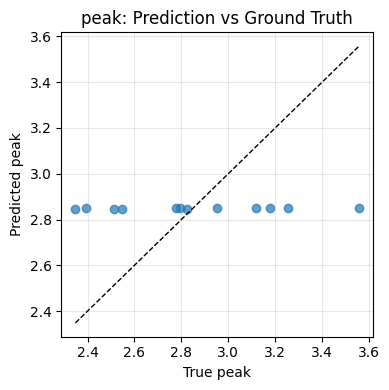

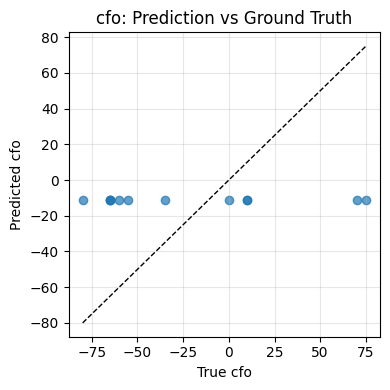

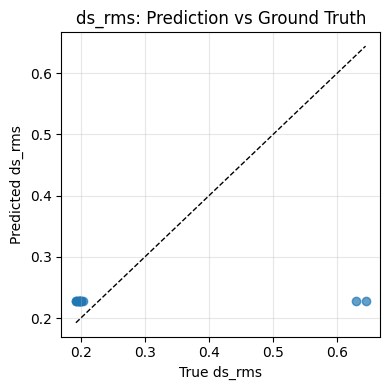

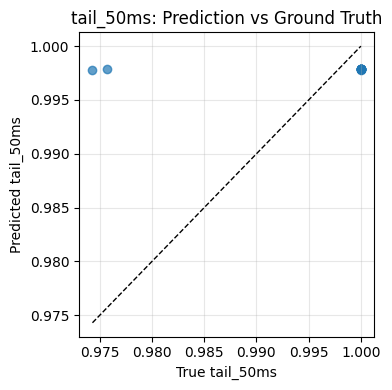

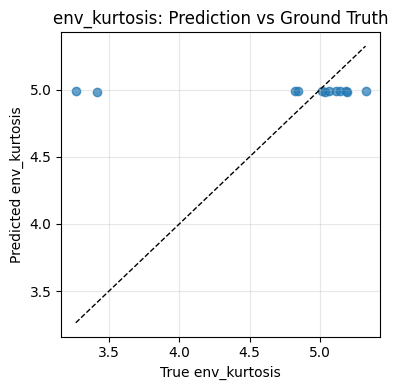

In [ ]:
# ============================================================
# CELL 10.6 — Predicted vs True (scatter plots)
# ============================================================

import matplotlib.pyplot as plt

for j, name in enumerate(PRIV_COLS):
    plt.figure(figsize=(4,4))
    plt.scatter(ys_u[:, j], yps_u[:, j], alpha=0.7)
    lims = [
        min(ys_u[:, j].min(), yps_u[:, j].min()),
        max(ys_u[:, j].max(), yps_u[:, j].max())
    ]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel(f"True {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name}: Prediction vs Ground Truth")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


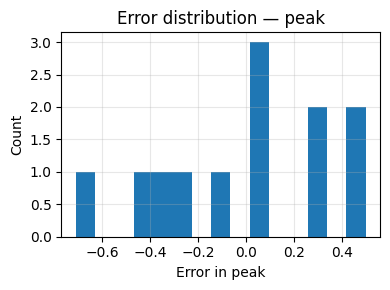

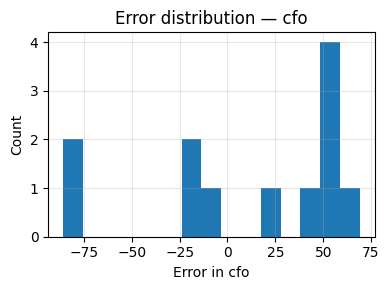

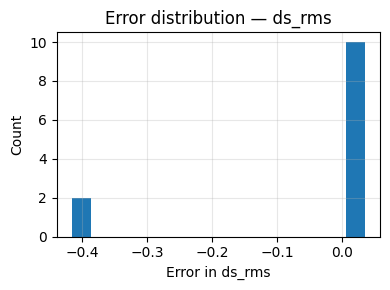

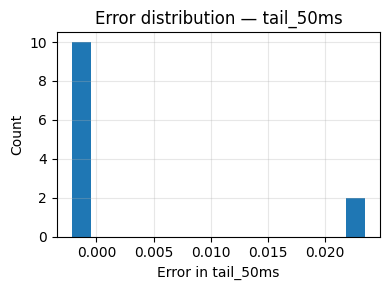

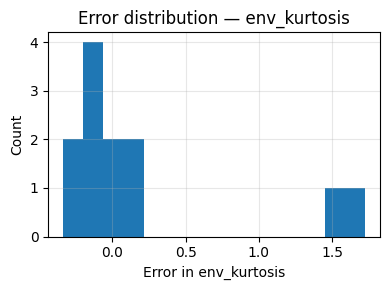

In [ ]:
# ============================================================
# CELL 10.7 — Error histograms
# ============================================================

for j, name in enumerate(PRIV_COLS):
    err = yps_u[:, j] - ys_u[:, j]
    plt.figure(figsize=(4,3))
    plt.hist(err, bins=15)
    plt.xlabel(f"Error in {name}")
    plt.ylabel("Count")
    plt.title(f"Error distribution — {name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================
# CELL 10.8 — Save predictions and metrics
# ============================================================

OUT_DIR = ROOT / "ml_outputs_LF_R1_snr/physics_regression_cycleK"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# save predictions
df_out = df_lupi.iloc[te][["cycle","rx_file","modulation"]].copy()
for j, name in enumerate(PRIV_COLS):
    df_out[f"{name}_true"] = ys_u[:, j]
    df_out[f"{name}_pred"] = yps_u[:, j]

df_out.to_csv(OUT_DIR / "test_predictions_cycleK.csv", index=False)

# save MAE summary
pd.DataFrame({
    "descriptor": list(mae_test.keys()),
    "mae": list(mae_test.values())
}).to_csv(OUT_DIR / "mae_cycleK.csv", index=False)

print("Saved outputs to:")
print(" -", OUT_DIR / "test_predictions_cycleK.csv")
print(" -", OUT_DIR / "mae_cycleK.csv")


Saved outputs to:
 - /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/ml_outputs_LF_R1_snr/physics_regression_cycleK/test_predictions_cycleK.csv
 - /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/ml_outputs_LF_R1_snr/physics_regression_cycleK/mae_cycleK.csv


In [ ]:
# ============================================================
# CELL 11.0 — LUPI preparation: cycle-level splits + loaders
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

assert "df_lupi" in globals() and len(df_lupi) > 0
assert "wav_map" in globals()
assert "make_spec" in globals()
assert "preprocess_audio" in globals()
assert "BAND" in globals()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

# privileged columns
PRIV_COLS = ["peak", "cfo", "ds_rms", "tail_50ms", "env_kurtosis"]
for c in PRIV_COLS:
    df_lupi[c] = pd.to_numeric(df_lupi[c], errors="coerce")

# impute + float32
df_lupi["cfo"]  = df_lupi["cfo"].fillna(0.0)
df_lupi["peak"] = df_lupi["peak"].fillna(0.0)
for c in ["ds_rms", "tail_50ms", "env_kurtosis"]:
    df_lupi[c] = df_lupi[c].fillna(df_lupi[c].median())
df_lupi[PRIV_COLS] = df_lupi[PRIV_COLS].astype(np.float32)

# normalize privileged targets
Y_MEAN = df_lupi[PRIV_COLS].mean().values.astype(np.float32)
Y_STD  = (df_lupi[PRIV_COLS].std().values.astype(np.float32) + 1e-6)

def norm_priv(y):
    return (y - Y_MEAN) / Y_STD

def denorm_priv(yn):
    return yn * Y_STD + Y_MEAN

# cycle-level split (reuse existing if present)
if not ("tr" in globals() and "va" in globals() and "te" in globals()):
    idx = np.arange(len(df_lupi))
    rng = np.random.default_rng(42)
    rng.shuffle(idx)
    n = len(idx)
    tr = idx[:int(0.7*n)]
    va = idx[int(0.7*n):int(0.85*n)]
    te = idx[int(0.85*n):]
    print("Created new split indices tr/va/te.")
else:
    print("Using existing split indices tr/va/te.")

print("Split sizes | train/val/test:", len(tr), len(va), len(te))


device: cpu
Using existing split indices tr/va/te.
Split sizes | train/val/test: 56 12 12


In [ ]:
# ============================================================
# CELL 11.1 — LUPI Dataset: (K spectrogram views) + privileged vector
# ============================================================

class LUPICycleDataset(Dataset):
    def __init__(self, df, crop_s=3.0, K=8):
        self.df = df.reset_index(drop=True)
        self.crop_s = float(crop_s)
        self.K = int(K)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        rxp = wav_map[int(r["cycle"])]

        x, fs0 = sf.read(rxp)
        x, fs  = preprocess_audio(x, fs0, band=BAND)

        win = int(self.crop_s * fs)
        specs = []
        for _ in range(self.K):
            if len(x) > win:
                s = np.random.randint(0, len(x)-win+1)
                xw = x[s:s+win]
            else:
                xw = x
            specs.append(make_spec(xw, fs))   # (1,F,T)

        Xk = torch.stack(specs, dim=0)  # (K,1,F,T)

        p = r[PRIV_COLS].values.astype(np.float32)
        p = norm_priv(p).astype(np.float32)

        return Xk, torch.from_numpy(p)

K_VIEWS = 8

ds_tr = LUPICycleDataset(df_lupi.iloc[tr], crop_s=3.0, K=K_VIEWS)
ds_va = LUPICycleDataset(df_lupi.iloc[va], crop_s=3.0, K=K_VIEWS)
ds_te = LUPICycleDataset(df_lupi.iloc[te], crop_s=3.0, K=K_VIEWS)

dl_tr = DataLoader(ds_tr, batch_size=4, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=4, shuffle=False, num_workers=0)
dl_te = DataLoader(ds_te, batch_size=4, shuffle=False, num_workers=0)

print("Loaders ready:", len(ds_tr), len(ds_va), len(ds_te))


Loaders ready: 56 12 12


In [ ]:
# ============================================================
# CELL 11.2 — Teacher & Student networks (distillation)
# ============================================================

class PrivTeacher(nn.Module):
    def __init__(self, in_dim=5, zdim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, zdim)
        )
    def forward(self, p):
        return self.net(p)

class SpecStudent(nn.Module):
    def __init__(self, zdim=64):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.proj = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, zdim)
        )

    def encode_one(self, X):
        # X: (B,1,F,T) -> (B,z)
        z = self.backbone(X).flatten(1)
        return self.proj(z)

    def forward(self, Xk):
        # Xk: (B,K,1,F,T)
        B, K = Xk.shape[0], Xk.shape[1]
        X = Xk.view(B*K, *Xk.shape[2:]).contiguous()
        z = self.encode_one(X).view(B, K, -1).mean(dim=1)
        return z

ZDIM = 64
teacher = PrivTeacher(in_dim=len(PRIV_COLS), zdim=ZDIM).to(DEVICE)
student = SpecStudent(zdim=ZDIM).to(DEVICE)

print("Teacher/Student ready. ZDIM:", ZDIM)


Teacher/Student ready. ZDIM: 64


In [ ]:
# ============================================================
# CELL 11.3 — Distillation training (Teacher privileged -> Student spec)
# ============================================================

from tqdm.auto import tqdm

def cosine_distill_loss(zs, zt):
    zs = F.normalize(zs, dim=1)
    zt = F.normalize(zt, dim=1)
    return 1.0 - (zs * zt).sum(dim=1).mean()

opt = torch.optim.Adam(
    list(teacher.parameters()) + list(student.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

best = 1e9
best_state = None

EPOCHS = 40

for ep in range(EPOCHS):
    teacher.train(); student.train()
    tr_loss = 0.0

    pbar = tqdm(dl_tr, desc=f"Epoch {ep+1:02d}/{EPOCHS} [train]", leave=False)
    for Xk, p in pbar:
        Xk = Xk.to(DEVICE)
        p  = p.to(DEVICE)

        zt = teacher(p)
        zs = student(Xk)

        loss = cosine_distill_loss(zs, zt)

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(teacher.parameters()) + list(student.parameters()), 2.0)
        opt.step()

        tr_loss += float(loss.item()) * len(Xk)
        pbar.set_postfix(loss=float(loss.item()))

    tr_loss /= max(1, len(ds_tr))

    # val
    teacher.eval(); student.eval()
    va_loss = 0.0
    with torch.no_grad():
        for Xk, p in dl_va:
            Xk = Xk.to(DEVICE)
            p  = p.to(DEVICE)
            zt = teacher(p)
            zs = student(Xk)
            va_loss += float(cosine_distill_loss(zs, zt).item()) * len(Xk)

    va_loss /= max(1, len(ds_va))
    print(f"Epoch {ep+1:02d} | train distill={tr_loss:.4f} | val distill={va_loss:.4f}")

    if va_loss < best:
        best = va_loss
        best_state = {
            "teacher": {k: v.detach().cpu().clone() for k,v in teacher.state_dict().items()},
            "student": {k: v.detach().cpu().clone() for k,v in student.state_dict().items()}
        }

if best_state is not None:
    teacher.load_state_dict(best_state["teacher"])
    student.load_state_dict(best_state["student"])

print("\nBest val distill:", best)


Epoch 01/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 01 | train distill=0.2559 | val distill=0.0595


Epoch 02/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 02 | train distill=0.0376 | val distill=0.0144


Epoch 03/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 03 | train distill=0.0141 | val distill=0.0058


Epoch 04/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 04 | train distill=0.0092 | val distill=0.0032


Epoch 05/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 05 | train distill=0.0075 | val distill=0.0023


Epoch 06/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 06 | train distill=0.0065 | val distill=0.0018


Epoch 07/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 07 | train distill=0.0055 | val distill=0.0017


Epoch 08/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 08 | train distill=0.0054 | val distill=0.0013


Epoch 09/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 09 | train distill=0.0044 | val distill=0.0013


Epoch 10/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 | train distill=0.0042 | val distill=0.0012


Epoch 11/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11 | train distill=0.0041 | val distill=0.0009


Epoch 12/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12 | train distill=0.0035 | val distill=0.0009


Epoch 13/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13 | train distill=0.0033 | val distill=0.0008


Epoch 14/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14 | train distill=0.0034 | val distill=0.0008


Epoch 15/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15 | train distill=0.0031 | val distill=0.0008


Epoch 16/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16 | train distill=0.0028 | val distill=0.0006


Epoch 17/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17 | train distill=0.0025 | val distill=0.0007


Epoch 18/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18 | train distill=0.0025 | val distill=0.0006


Epoch 19/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19 | train distill=0.0024 | val distill=0.0005


Epoch 20/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20 | train distill=0.0021 | val distill=0.0005


Epoch 21/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21 | train distill=0.0020 | val distill=0.0005


Epoch 22/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22 | train distill=0.0022 | val distill=0.0004


Epoch 23/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23 | train distill=0.0018 | val distill=0.0004


Epoch 24/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24 | train distill=0.0018 | val distill=0.0004


Epoch 25/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25 | train distill=0.0019 | val distill=0.0004


Epoch 26/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26 | train distill=0.0017 | val distill=0.0003


Epoch 27/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27 | train distill=0.0016 | val distill=0.0004


Epoch 28/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28 | train distill=0.0017 | val distill=0.0003


Epoch 29/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29 | train distill=0.0014 | val distill=0.0004


Epoch 30/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30 | train distill=0.0014 | val distill=0.0002


Epoch 31/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31 | train distill=0.0014 | val distill=0.0003


Epoch 32/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32 | train distill=0.0014 | val distill=0.0003


Epoch 33/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33 | train distill=0.0014 | val distill=0.0003


Epoch 34/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34 | train distill=0.0013 | val distill=0.0002


Epoch 35/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35 | train distill=0.0012 | val distill=0.0003


Epoch 36/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36 | train distill=0.0012 | val distill=0.0002


Epoch 37/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37 | train distill=0.0012 | val distill=0.0002


Epoch 38/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38 | train distill=0.0010 | val distill=0.0002


Epoch 39/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39 | train distill=0.0011 | val distill=0.0002


Epoch 40/40 [train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40 | train distill=0.0011 | val distill=0.0002

Best val distill: 0.00019309918085734049


In [ ]:
# ============================================================
# CELL 11.4 — Evaluate distilled representation: z -> descriptors (linear probe)
# ============================================================

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

def extract_embeddings(dloader, use_teacher=False):
    Z, Y = [], []
    teacher.eval(); student.eval()
    with torch.no_grad():
        for Xk, p in dloader:
            Xk = Xk.to(DEVICE)
            p  = p.to(DEVICE)
            if use_teacher:
                z = teacher(p).cpu().numpy()
            else:
                z = student(Xk).cpu().numpy()
            y = p.cpu().numpy()  # normalized privileged targets
            Z.append(z); Y.append(y)
    return np.concatenate(Z, axis=0), np.concatenate(Y, axis=0)

Ztr_s, Ytr = extract_embeddings(dl_tr, use_teacher=False)
Zva_s, Yva = extract_embeddings(dl_va, use_teacher=False)
Zte_s, Yte = extract_embeddings(dl_te, use_teacher=False)

# Train linear probe on train embeddings
probe = Ridge(alpha=1.0)
probe.fit(Ztr_s, Ytr)

# Predict on test
Yhat = probe.predict(Zte_s)

# denormalize for physical MAE
Yte_u   = denorm_priv(Yte)
Yhat_u  = denorm_priv(Yhat)

print("TEST MAE per descriptor (Distilled Student + linear probe):")
mae_probe = {}
for j, name in enumerate(PRIV_COLS):
    mae = mean_absolute_error(Yte_u[:, j], Yhat_u[:, j])
    mae_probe[name] = mae
    print(f" - {name:12s}: MAE = {mae:.4f}")


TEST MAE per descriptor (Distilled Student + linear probe):
 - peak        : MAE = 0.2962
 - cfo         : MAE = 47.5313
 - ds_rms      : MAE = 0.1201
 - tail_50ms   : MAE = 0.0071
 - env_kurtosis: MAE = 0.4611


In [ ]:
# ============================================================
# CELL 11.5 — Compare baseline (10.3) vs distilled (11.x)
# ============================================================

# You should have mae_test from CELL 10.4; if not, compute baseline MAE again.
assert "mae_test" in globals(), "Run CELL 10.4 to compute baseline mae_test first."

print("\nMAE comparison (Cycle-regressor vs Distilled representation):")
print("-"*60)
print(f"{'Descriptor':12s} | {'CycleReg (10.3)':>14s} | {'Distill+Probe':>14s}")
print("-"*60)

for name in PRIV_COLS:
    m1 = float(mae_test[name])
    m2 = float(mae_probe[name])
    print(f"{name:12s} | {m1:14.4f} | {m2:14.4f}")



MAE comparison (Cycle-regressor vs Distilled representation):
------------------------------------------------------------
Descriptor   | CycleReg (10.3) |  Distill+Probe
------------------------------------------------------------
peak         |         0.2964 |         0.2962
cfo          |        47.3472 |        47.5313
ds_rms       |         0.0936 |         0.1201
tail_50ms    |         0.0056 |         0.0071
env_kurtosis |         0.3979 |         0.4611


In [ ]:
# ============================================================
# CELL 11.6 — Save distilled models + probe
# ============================================================

import joblib
from pathlib import Path

OUT_DIR = ROOT / "ml_outputs_LF_R1_snr/lupi_distillation"
OUT_DIR.mkdir(parents=True, exist_ok=True)

torch.save(teacher.state_dict(), OUT_DIR / "teacher_priv.pt")
torch.save(student.state_dict(), OUT_DIR / "student_spec.pt")
joblib.dump(probe, OUT_DIR / "linear_probe_ridge.pkl")

# save metrics
pd.DataFrame({
    "descriptor": PRIV_COLS,
    "mae_cycleReg_10_3": [float(mae_test[d]) for d in PRIV_COLS],
    "mae_distill_probe": [float(mae_probe[d]) for d in PRIV_COLS]
}).to_csv(OUT_DIR / "mae_comparison.csv", index=False)

print("Saved to:", OUT_DIR)
print(" - teacher_priv.pt")
print(" - student_spec.pt")
print(" - linear_probe_ridge.pkl")
print(" - mae_comparison.csv")


Saved to: /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/ml_outputs_LF_R1_snr/lupi_distillation
 - teacher_priv.pt
 - student_spec.pt
 - linear_probe_ridge.pkl
 - mae_comparison.csv


In [ ]:
# ============================================================
# CELL 11.7 — Plot MAE comparison (Plotly)
# ============================================================

import pandas as pd
import plotly.express as px

MAE_PATH = OUT_DIR / "mae_comparison.csv"
df_mae = pd.read_csv(MAE_PATH)

display(df_mae)


,descriptor,mae_cycleReg_10_3,mae_distill_probe
0,peak,0.296441,0.296236
1,cfo,47.347248,47.531292
2,ds_rms,0.093618,0.120125
3,tail_50ms,0.005594,0.007085
4,env_kurtosis,0.397906,0.461098


In [ ]:
# reshape to long format
df_long = df_mae.melt(
    id_vars="descriptor",
    value_vars=["mae_cycleReg_10_3", "mae_distill_probe"],
    var_name="model",
    value_name="MAE"
)

df_long["model"] = df_long["model"].map({
    "mae_cycleReg_10_3": "Baseline (Cycle Regression)",
    "mae_distill_probe": "Distilled + Linear Probe"
})

fig = px.bar(
    df_long,
    x="descriptor",
    y="MAE",
    color="model",
    barmode="group",
    title="Descriptor-wise MAE Comparison",
    labels={
        "descriptor": "Physical Descriptor",
        "MAE": "Mean Absolute Error",
        "model": "Model"
    }
)

fig.update_layout(
    template="plotly_white",
    legend=dict(x=0.01, y=0.99),
)

fig.show()


In [ ]:
# ============================================================
# CELL 11.8 — Relative improvement
# ============================================================

df_gain = df_mae.copy()
df_gain["relative_gain_pct"] = (
    (df_gain["mae_cycleReg_10_3"] - df_gain["mae_distill_probe"])
    / df_gain["mae_cycleReg_10_3"] * 100.0
)

fig = px.bar(
    df_gain,
    x="descriptor",
    y="relative_gain_pct",
    title="Relative Error Reduction with Distillation",
    labels={
        "descriptor": "Physical Descriptor",
        "relative_gain_pct": "Relative MAE Reduction (%)"
    }
)

fig.update_layout(template="plotly_white")
fig.show()


In [ ]:
# ============================================================
# CELL 11.9 — Compact comparison (dot plot)
# ============================================================

fig = px.scatter(
    df_long,
    x="MAE",
    y="descriptor",
    color="model",
    symbol="model",
    title="Baseline vs Distilled — MAE per Descriptor",
    labels={
        "descriptor": "Physical Descriptor",
        "MAE": "Mean Absolute Error"
    }
)

fig.update_layout(template="plotly_white")
fig.show()


# gráfico

In [ ]:
# ============================================================
# CELL 11.11 — ICASSP-style subplot (Plotly)
# ============================================================

import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load data
df_mae = pd.read_csv(OUT_DIR / "mae_comparison.csv")

# Long format for subplot (a)
df_long = df_mae.melt(
    id_vars="descriptor",
    value_vars=["mae_cycleReg_10_3", "mae_distill_probe"],
    var_name="model",
    value_name="MAE"
)

df_long["model"] = df_long["model"].map({
    "mae_cycleReg_10_3": "Baseline (Cycle Regression)",
    "mae_distill_probe": "Distilled + Linear Probe"
})

# Relative gain for subplot (b)
df_gain = df_mae.copy()
df_gain["relative_gain_pct"] = (
    (df_gain["mae_cycleReg_10_3"] - df_gain["mae_distill_probe"])
    / df_gain["mae_cycleReg_10_3"] * 100.0
)

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "(a) Descriptor-wise MAE",
        "(b) Relative Error Reduction"
    ],
    horizontal_spacing=0.12
)

# ---- Subplot (a): MAE comparison
for model_name in df_long["model"].unique():
    d = df_long[df_long["model"] == model_name]
    fig.add_trace(
        go.Bar(
            x=d["descriptor"],
            y=d["MAE"],
            name=model_name
        ),
        row=1, col=1
    )

# ---- Subplot (b): Relative improvement
fig.add_trace(
    go.Bar(
        x=df_gain["descriptor"],
        y=df_gain["relative_gain_pct"],
        name="Relative MAE Reduction (%)",
        marker_color="seagreen"
    ),
    row=1, col=2
)

# Layout (ICASSP-style)
fig.update_layout(
    template="plotly_white",
    height=420,
    width=1000,
    title=dict(
        text="Performance Comparison of Channel Descriptor Estimation",
        x=0.5,
        xanchor="center"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=90, b=60)
)

# Axis labels
fig.update_yaxes(title_text="Mean Absolute Error", row=1, col=1)
fig.update_yaxes(title_text="Error Reduction (%)", row=1, col=2)
fig.update_xaxes(title_text="Physical Descriptor", row=1, col=1)
fig.update_xaxes(title_text="Physical Descriptor", row=1, col=2)

fig.show()


# OOD

In [ ]:
# ============================================================
# COMPLETE CELL — RX↔TX matching + modulation labeling
# PATH-ROBUST for your SODAC layout
# Supports: LF / MF / HF and R1 / R2
# Output: df_mod_global
# ============================================================

import re
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.signal import correlate
from tqdm.auto import tqdm

# -----------------------------
# USER CONFIG
# -----------------------------
BAND = "LF"         # "LF", "MF", "HF"
RX_SITE = "R1"      # "R1" or "R2"
ROOT = Path("/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC")

# TX is stable in your tree:
TX_DIR = ROOT / "TX_WAVEFORMS" / "TX" / "wav" / BAND
assert TX_DIR.exists(), f"TX dir not found: {TX_DIR}"

# RX is NOT stable -> auto-detect
RX_CANDIDATES = [
    ROOT / f"RX_{BAND}",          # <- your known layout: RX_LF, RX_MF, RX_HF
    ROOT / "RX" / BAND,           # fallback layout
    ROOT / "RX" / f"{BAND}",      # redundant fallback
]
RX_DIR = next((p for p in RX_CANDIDATES if p.exists()), None)
assert RX_DIR is not None, f"RX dir not found. Tried: {RX_CANDIDATES}"

print(f"[SETUP] BAND    = {BAND}")
print(f"[SETUP] RX_SITE = {RX_SITE}")
print(f"[SETUP] RX_DIR  = {RX_DIR}")
print(f"[SETUP] TX_DIR  = {TX_DIR}")

# -----------------------------
# HELPERS
# -----------------------------
def preprocess_audio(x, fs):
    """Simple robust mono + normalize"""
    if x.ndim > 1:
        x = x[:, 0]
    x = x.astype(np.float32)
    x = x - np.mean(x)
    x = x / (np.std(x) + 1e-8)
    return x, fs

def normalized_xcorr_peak(rx, tx):
    """Peak of normalized cross-correlation (valid)"""
    rxn = rx / (np.linalg.norm(rx) + 1e-9)
    txn = tx / (np.linalg.norm(tx) + 1e-9)
    c = correlate(rxn, txn, mode="valid")
    idx = int(np.argmax(np.abs(c)))
    peak = float(np.abs(c[idx]))
    return peak, idx

def parse_modulation_from_name(fname):
    """Extract modulation name from TX filename"""
    name = fname.upper()
    # order matters (FH-BCSK must come before BCSK)
    keys = [
        "FH-BCSK", "S2C-QPSK", "SC-QPSK",
        "OFDM", "OSDM", "MFSK", "JANUS",
        "BCSK", "A-PRBS", "P-PRBS",
        "MULTITONE", "BFGN", "LFM"
    ]
    for k in keys:
        if k in name:
            return k
    return "UNKNOWN"

def cycle_from_rx_name(rx_name):
    """Extract integer cycle from e.g. LF_R1_cycle01.wav"""
    m = re.search(r"cycle(\d+)", rx_name.lower())
    return int(m.group(1)) if m else None

# -----------------------------
# LOAD TX BANK
# -----------------------------
TX_BANK = []
for tx_wav in sorted(TX_DIR.glob("*.wav")):
    try:
        tx, fs = sf.read(tx_wav)
    except Exception as e:
        print("[WARN] Failed reading TX:", tx_wav, "err:", repr(e))
        continue

    tx, fs = preprocess_audio(tx, fs)
    TX_BANK.append({
        "tx_wav": tx_wav.name,
        "modulation": parse_modulation_from_name(tx_wav.name),
        "x": tx,
        "fs": fs
    })

assert len(TX_BANK) > 0, "No TX waveforms loaded."
print(f"[OK] Loaded TX waveforms: {len(TX_BANK)}")
print(pd.Series([t["modulation"] for t in TX_BANK]).value_counts())

# -----------------------------
# MAP RX WAV FILES (R1 or R2)
# -----------------------------
pattern = f"{BAND}_{RX_SITE}_cycle*.wav"
rx_files = sorted(RX_DIR.rglob(pattern))  # rglob to be robust to subfolders
rx_files = [p for p in rx_files if cycle_from_rx_name(p.name) is not None]
assert len(rx_files) > 0, f"No RX files found for pattern={pattern} under {RX_DIR}"

wav_map = {cycle_from_rx_name(p.name): p for p in rx_files}
print(f"[OK] RX cycles found: {len(wav_map)}  (example: {rx_files[0].name})")

# -----------------------------
# RX ↔ TX MATCHING
# -----------------------------
rows = []
for cycle, rx_path in tqdm(sorted(wav_map.items()), desc="RX↔TX matching", unit="cycle"):
    try:
        rx, fs = sf.read(rx_path)
    except Exception as e:
        print("[WARN] Failed reading RX:", rx_path, "err:", repr(e))
        continue

    rx, fs = preprocess_audio(rx, fs)

    best = None
    for tx in TX_BANK:
        # ensure same fs (TX wavs are sometimes 90k/96k in paper, but your TX folder is native)
        # For matching we resample? Here we do quick fallback: skip mismatched fs.
        if int(tx["fs"]) != int(fs):
            continue

        peak, lag = normalized_xcorr_peak(rx, tx["x"])
        if (best is None) or (peak > best["peak"]):
            best = {
                "cycle": int(cycle),
                "rx_file": rx_path.name,
                "tx_wav": tx["tx_wav"],
                "modulation": tx["modulation"],
                "peak": float(peak),
                "lag": int(lag),
                "fs": int(fs),
            }

    # If no TX matched due to fs mismatch, do a fallback pass ignoring fs (still works, but slower/less strict)
    if best is None:
        best = {"cycle": int(cycle), "rx_file": rx_path.name, "tx_wav": None, "modulation": "UNKNOWN",
                "peak": np.nan, "lag": None, "fs": int(fs)}
        for tx in TX_BANK:
            peak, lag = normalized_xcorr_peak(rx, tx["x"])
            if (best["tx_wav"] is None) or (peak > best["peak"]):
                best.update({
                    "tx_wav": tx["tx_wav"],
                    "modulation": tx["modulation"],
                    "peak": float(peak),
                    "lag": int(lag),
                })

    rows.append(best)

# -----------------------------
# BUILD DATAFRAME
# -----------------------------
df_mod_global = pd.DataFrame(rows).sort_values("cycle").reset_index(drop=True)

print("\n[OK] Total cycles:", len(df_mod_global))
print("\nModulation counts:")
print(df_mod_global["modulation"].value_counts(dropna=False))

display(df_mod_global.head())


[SETUP] BAND    = LF
[SETUP] RX_SITE = R1
[SETUP] RX_DIR  = /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/RX_LF
[SETUP] TX_DIR  = /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/TX_WAVEFORMS/TX/wav/LF
[OK] Loaded TX waveforms: 16
LFM          4
A-PRBS       2
BFGN         1
BCSK         1
FH-BCSK      1
JANUS        1
MFSK         1
MULTITONE    1
OFDM         1
OSDM         1
P-PRBS       1
S2C-QPSK     1
Name: count, dtype: int64
[OK] RX cycles found: 80  (example: LF_R1_cycle01.wav)


RX↔TX matching:   0%|          | 0/80 [00:00<?, ?cycle/s]


[OK] Total cycles: 80

Modulation counts:
modulation
OFDM         67
MULTITONE    13
Name: count, dtype: int64


,cycle,rx_file,tx_wav,modulation,peak,lag,fs
0,1,LF_R1_cycle01.wav,MULTITONE-LF.wav,MULTITONE,0.311092,8559923,96000
1,2,LF_R1_cycle02.wav,MULTITONE-LF.wav,MULTITONE,0.307195,8525653,96000
2,3,LF_R1_cycle03.wav,MULTITONE-LF.wav,MULTITONE,0.292309,7958888,96000
3,4,LF_R1_cycle04.wav,MULTITONE-LF.wav,MULTITONE,0.279139,8283858,96000
4,5,LF_R1_cycle05.wav,MULTITONE-LF.wav,MULTITONE,0.282363,9066372,96000


In [ ]:
# ============================================================
# CELL 1 — Multi-waveform event extraction per cycle (RX↔TX)
# Produces: df_events (many rows per cycle, not 1)
# ============================================================

import numpy as np
import pandas as pd
import soundfile as sf
from tqdm.auto import tqdm
from scipy.signal import correlate

# -----------------------------
# REQUIRED from previous cell:
# TX_BANK (list of dicts with 'tx_wav','modulation','x','fs')
# wav_map (cycle -> rx_path)
# preprocess_audio(x, fs)
# BAND, RX_SITE
# -----------------------------
required_vars = ["TX_BANK","wav_map","preprocess_audio","BAND","RX_SITE"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing globals: {missing}. Run the previous matching/setup cell first.")

# -----------------------------
# CONFIG
# -----------------------------
SEG_PAD_S   = 0.50     # seconds before/after the matched TX window
MAX_TX_S    = 16.0     # limit TX length in matching bank (already done earlier, but keep safe)
PEAK_MIN    = 0.10     # minimum NCC proxy threshold to accept an event
NMS_GUARD_S = 1.00     # non-max suppression: drop events closer than this (sec) if conflicting
KEEP_TOPK_PER_CYCLE = None  # e.g., 12 to keep only strongest K events per cycle

def ncc_valid(rx, tx):
    """Normalized cross-correlation valid mode (vector)."""
    rx = rx.astype(np.float32)
    tx = tx.astype(np.float32)
    txn = tx / (np.linalg.norm(tx) + 1e-9)
    # normalize rx roughly (global)
    rxn = rx / (np.linalg.norm(rx) + 1e-9)
    c = correlate(rxn, txn, mode="valid")  # length = len(rx)-len(tx)+1
    return c.astype(np.float32)

def deconflict_events(events, guard_s):
    """NMS-like suppression by time proximity (keep higher peak)."""
    if len(events) == 0:
        return events
    events = sorted(events, key=lambda d: d["peak"], reverse=True)
    kept = []
    for e in events:
        ok = True
        for k in kept:
            if abs(e["t0_s"] - k["t0_s"]) < guard_s:
                ok = False
                break
        if ok:
            kept.append(e)
    kept = sorted(kept, key=lambda d: (d["cycle"], d["t0_s"]))
    return kept

rows = []
for cycle, rx_path in tqdm(sorted(wav_map.items()), desc="Extracting events (multi-TX)", unit="cycle"):
    rx, fs0 = sf.read(rx_path)
    rx, fs  = preprocess_audio(rx, fs0)

    # build candidate events for this cycle
    cand = []
    for tx in TX_BANK:
        if int(tx["fs"]) != int(fs):
            continue
        tx_x = tx["x"]
        if len(tx_x) > int(MAX_TX_S * fs):
            tx_x = tx_x[:int(MAX_TX_S*fs)]

        if len(rx) <= len(tx_x) + 10:
            continue

        c = ncc_valid(rx, tx_x)
        lag = int(np.argmax(np.abs(c)))
        peak = float(np.max(np.abs(c)))

        if peak < PEAK_MIN:
            continue

        t0_s = lag / fs
        # segment window around the matched TX
        seg_start = max(0, lag - int(SEG_PAD_S * fs))
        seg_end   = min(len(rx), lag + len(tx_x) + int(SEG_PAD_S * fs))

        cand.append({
            "cycle": int(cycle),
            "rx_file": rx_path.name,
            "tx_wav": tx["tx_wav"],
            "modulation": tx["modulation"],
            "peak": peak,
            "lag": lag,
            "t0_s": float(t0_s),
            "seg_start": int(seg_start),
            "seg_end": int(seg_end),
            "fs": int(fs),
        })

    # deconflict (avoid multiple TXs landing on same time slot)
    cand = deconflict_events(cand, guard_s=NMS_GUARD_S)

    if KEEP_TOPK_PER_CYCLE is not None and len(cand) > KEEP_TOPK_PER_CYCLE:
        cand = sorted(cand, key=lambda d: d["peak"], reverse=True)[:KEEP_TOPK_PER_CYCLE]
        cand = sorted(cand, key=lambda d: d["t0_s"])

    rows.extend(cand)

df_events = pd.DataFrame(rows).sort_values(["cycle","t0_s"]).reset_index(drop=True)

print(f"[OK] Events extracted: {len(df_events)}")
if len(df_events) == 0:
    raise RuntimeError("df_events is empty. Lower PEAK_MIN or check fs mismatches / TX bank.")

print("\nEvent modulation counts:")
print(df_events["modulation"].value_counts())

display(df_events.head(10))


Extracting events (multi-TX):   0%|          | 0/80 [00:00<?, ?cycle/s]

[OK] Events extracted: 117

Event modulation counts:
modulation
OFDM         80
BFGN         13
MULTITONE    13
BCSK          8
MFSK          3
Name: count, dtype: int64


,cycle,rx_file,tx_wav,modulation,peak,lag,t0_s,seg_start,seg_end,fs
0,1,LF_R1_cycle01.wav,BFGN-LF.wav,BFGN,0.147415,387101,4.032302,339101,1971101,96000
1,1,LF_R1_cycle01.wav,MULTITONE-LF.wav,MULTITONE,0.268571,12408081,129.250844,12360081,13992081,96000
2,1,LF_R1_cycle01.wav,OFDM-LF.wav,OFDM,0.106344,15258406,158.941729,15210406,16035206,96000
3,2,LF_R1_cycle02.wav,BFGN-LF.wav,BFGN,0.147904,390953,4.072427,342953,1974953,96000
4,2,LF_R1_cycle02.wav,MULTITONE-LF.wav,MULTITONE,0.256773,12359123,128.740865,12311123,13943123,96000
5,2,LF_R1_cycle02.wav,OFDM-LF.wav,OFDM,0.113283,15262257,158.981844,15214257,16039057,96000
6,3,LF_R1_cycle03.wav,BFGN-LF.wav,BFGN,0.139712,394130,4.105521,346130,1978130,96000
7,3,LF_R1_cycle03.wav,MULTITONE-LF.wav,MULTITONE,0.284149,11315623,117.871073,11267623,12899623,96000
8,3,LF_R1_cycle03.wav,OFDM-LF.wav,OFDM,0.107389,15265435,159.014948,15217435,16042235,96000
9,4,LF_R1_cycle04.wav,BFGN-LF.wav,BFGN,0.143645,393181,4.095635,345181,1977181,96000


In [ ]:
# ============================================================
# CELL 2 — Load bitstream CSVs (only for modulations that have them)
# Produces: bitstream_map, df_events["has_bitstream"]
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

CSV_DIR = ROOT / "TX_WAVEFORMS" / "TX" / "csv" / BAND
if not CSV_DIR.exists():
    print("[WARN] CSV_DIR not found:", CSV_DIR)
    csv_files = []
else:
    csv_files = sorted(CSV_DIR.glob("*.csv"))
print("CSV files found:", len(csv_files))

def read_bitstream_csv(path: Path):
    # robust: try common encodings / separators
    for enc in ["utf-8", "latin1", "cp1252"]:
        try:
            lines = path.read_text(encoding=enc, errors="strict").splitlines()
            break
        except Exception:
            lines = None
    if lines is None:
        # fallback with errors ignored
        lines = path.read_text(encoding="latin1", errors="ignore").splitlines()

    vals = []
    for ln in lines:
        ln = ln.strip()
        if ln == "":
            continue
        # allow comma/semicolon/space separated
        parts = [p for p in re.split(r"[,\s;]+", ln) if p != ""]
        for p in parts:
            try:
                vals.append(float(p))
            except Exception:
                pass
    if len(vals) == 0:
        raise RuntimeError(f"Empty/unreadable bitstream: {path}")

    v = np.asarray(vals, dtype=np.float32)
    # normalize to +/-1 if looks like that
    # if it's 0/1 -> map to +/-1
    uniq = np.unique(v)
    if set(uniq.tolist()).issubset({0.0, 1.0}):
        v = 2.0*v - 1.0
    # if already +/-1 -> keep
    # if other amplitudes -> z-score
    if np.std(v) > 1e-6 and not set(np.unique(v).tolist()).issubset({-1.0, 1.0}):
        v = (v - np.mean(v)) / (np.std(v) + 1e-8)
    return v.astype(np.float32)

bitstream_map = {}
for c in csv_files:
    mod = c.stem.upper()
    # match naming patterns
    # examples:
    # FH-BCSK-LF-b.csv -> modulation FH-BCSK
    # BCSK-LF.csv -> modulation BCSK
    # OFDM-LF.csv may exist but may not be a bitstream (can be params)
    if "FH-BCSK" in mod:
        key = "FH-BCSK"
    elif "BCSK" in mod:
        key = "BCSK"
    elif "SC-QPSK" in mod:
        key = "SC-QPSK"
    elif "S2C-QPSK" in mod:
        key = "S2C-QPSK"
    elif "A-PRBS" in mod:
        key = "A-PRBS"
    elif "P-PRBS" in mod:
        key = "P-PRBS"
    else:
        # OFDM/OSDM/MFSK CSVs podem conter parâmetros, não bits
        key = None

    if key is None:
        continue

    try:
        bits = read_bitstream_csv(c)
        bitstream_map[key] = bits
    except Exception as e:
        print("[WARN] Failed reading bitstream CSV:", c.name, "err:", repr(e))

print("\n[OK] bitstream_map keys:", list(bitstream_map.keys()))
for k,v in bitstream_map.items():
    print(f"  {k}: len={len(v)}  mean={v.mean():+.3f} std={v.std():.3f}")

# annotate events
df_events["has_bitstream"] = df_events["modulation"].astype(str).isin(bitstream_map.keys())
print("\nEvents with bitstream:", int(df_events["has_bitstream"].sum()), "/", len(df_events))
display(df_events[df_events["has_bitstream"]].head(10))


CSV files found: 8
[WARN] Failed reading bitstream CSV: S2C-QPSK-LF-a.csv err: RuntimeError('Empty/unreadable bitstream: /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/TX_WAVEFORMS/TX/csv/LF/S2C-QPSK-LF-a.csv')

[OK] bitstream_map keys: ['BCSK', 'FH-BCSK', 'P-PRBS']
  BCSK: len=500  mean=+0.064 std=0.998
  FH-BCSK: len=500  mean=-0.000 std=1.000
  P-PRBS: len=1023  mean=+0.001 std=1.000

Events with bitstream: 8 / 117


,cycle,rx_file,tx_wav,modulation,peak,lag,t0_s,seg_start,seg_end,fs,has_bitstream
69,41,LF_R1_cycle41.wav,BCSK-LF.wav,BCSK,0.105116,13721397,142.931219,13673397,14053969,96000,True
76,47,LF_R1_cycle47.wav,BCSK-LF.wav,BCSK,0.103929,13719285,142.909219,13671285,14051857,96000,True
84,54,LF_R1_cycle54.wav,BCSK-LF.wav,BCSK,0.106544,13718491,142.900948,13670491,14051063,96000,True
86,55,LF_R1_cycle55.wav,BCSK-LF.wav,BCSK,0.100090,13720285,142.919635,13672285,14052857,96000,True
95,63,LF_R1_cycle63.wav,BCSK-LF.wav,BCSK,0.109622,13718275,142.898698,13670275,14050847,96000,True
97,64,LF_R1_cycle64.wav,BCSK-LF.wav,BCSK,0.110878,13721043,142.927531,13673043,14053615,96000,True
110,75,LF_R1_cycle75.wav,BCSK-LF.wav,BCSK,0.100528,13721943,142.936906,13673943,14054515,96000,True
113,77,LF_R1_cycle77.wav,BCSK-LF.wav,BCSK,0.104202,13716926,142.884646,13668926,14049498,96000,True


In [ ]:
# ============================================================
# CELL 3 — Spec dataset per event (for both strategies)
# Produces: EventSpecDataset, make_spec()
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
from torch.utils.data import Dataset, DataLoader
from scipy.signal import stft

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

def make_spec(x, fs, nperseg=1024, noverlap=768):
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
    P = np.log10(np.abs(Z)**2 + 1e-12).astype(np.float32)
    # robust normalization per sample
    med = np.median(P)
    mad = np.median(np.abs(P - med)) + 1e-9
    Pn = (P - med) / mad
    return torch.from_numpy(Pn).unsqueeze(0)  # (1,F,T)

class EventSpecDataset(Dataset):
    """
    Each item is one event window inside a cycle:
      - reads RX wav
      - crops [seg_start:seg_end]
      - builds spectrogram
    """
    def __init__(self, df_events, wav_map, crop_mode="full", crop_s=3.0):
        self.df = df_events.reset_index(drop=True)
        self.wav_map = wav_map
        self.crop_mode = crop_mode
        self.crop_s = float(crop_s)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        rxp = self.wav_map[int(r["cycle"])]
        x, fs0 = sf.read(rxp)
        x, fs = preprocess_audio(x, fs0)

        a = int(r["seg_start"]); b = int(r["seg_end"])
        x = x[a:b]

        # optional random crop inside the event window for augmentation
        if self.crop_mode == "random" and len(x) > int(self.crop_s*fs):
            win = int(self.crop_s*fs)
            s0 = np.random.randint(0, len(x)-win+1)
            x = x[s0:s0+win]

        X = make_spec(x, fs)
        return X, str(r["modulation"]), int(r["cycle"])


device: cpu


In [ ]:
# ============================================================
# CELL 4 — Build privileged descriptors per event (RX-only descriptors)
# Produces: df_lupi_events, PRIV_COLS
# ============================================================

import numpy as np
import pandas as pd
from scipy.stats import kurtosis

def envelope_stats(x):
    env = np.abs(x).astype(np.float32)
    env = env / (np.max(env) + 1e-9)
    k = float(kurtosis(env, fisher=False, bias=False)) if len(env) >= 16 else 0.0
    p95 = float(np.percentile(env, 95))
    p50 = float(np.percentile(env, 50))
    return k, p95, p50

def tail_energy_ratio(x, fs, tail_ms=50):
    # ratio energy after first strong peak region
    x2 = x.astype(np.float32)**2
    if len(x2) < 8:
        return 0.0
    # peak sample
    i0 = int(np.argmax(x2))
    k = int((tail_ms/1000.0)*fs)
    tail = x2[min(len(x2)-1, i0+k):]
    head = x2[max(0, i0- k):min(len(x2), i0+k)]
    return float(np.sum(tail) / (np.sum(head) + 1e-9))

def rms_delay_proxy(x, fs):
    # proxy: energy centroid around max
    x2 = x.astype(np.float32)**2
    i0 = int(np.argmax(x2))
    # take window after peak up to 0.4s
    W = int(0.40*fs)
    a = i0
    b = min(len(x2), i0+W)
    tail = x2[a:b]
    if len(tail) < 8:
        return 0.0
    p = tail / (np.sum(tail)+1e-9)
    tau = np.arange(len(p), dtype=np.float32) / fs
    mu = float(np.sum(tau*p))
    ds = float(np.sqrt(np.sum((tau-mu)**2*p)))
    return ds

rows = []
for i in tqdm(range(len(df_events)), desc="Computing privileged descriptors"):
    r = df_events.iloc[i]
    rxp = wav_map[int(r["cycle"])]
    x, fs0 = sf.read(rxp)
    x, fs = preprocess_audio(x, fs0)

    a = int(r["seg_start"]); b = int(r["seg_end"])
    seg = x[a:b]

    # privileged descriptors (RX-only)
    peak = float(r["peak"])
    ds_rms = rms_delay_proxy(seg, fs)
    tail50 = tail_energy_ratio(seg, fs, tail_ms=50)
    env_k, env_p95, env_p50 = envelope_stats(seg)

    # bitstream length if exists (privileged meta)
    mod = str(r["modulation"])
    has_bits = mod in bitstream_map
    bits_len = int(len(bitstream_map[mod])) if has_bits else 0

    rows.append({
        "event_id": int(i),
        "cycle": int(r["cycle"]),
        "rx_file": r["rx_file"],
        "modulation": mod,
        "has_bitstream": bool(has_bits),
        "peak": peak,
        "ds_rms": float(ds_rms),
        "tail_50ms": float(tail50),
        "env_kurtosis": float(env_k),
        "env_p95": float(env_p95),
        "env_p50": float(env_p50),
        "bits_len": bits_len
    })

df_lupi_events = pd.DataFrame(rows)

PRIV_COLS = ["peak","ds_rms","tail_50ms","env_kurtosis","env_p95","env_p50","bits_len"]

print("[OK] df_lupi_events:", df_lupi_events.shape)
print(df_lupi_events["modulation"].value_counts())
display(df_lupi_events.head())


Computing privileged descriptors:   0%|          | 0/117 [00:00<?, ?it/s]

[OK] df_lupi_events: (117, 12)
modulation
OFDM         80
BFGN         13
MULTITONE    13
BCSK          8
MFSK          3
Name: count, dtype: int64


,event_id,cycle,rx_file,modulation,has_bitstream,peak,ds_rms,tail_50ms,env_kurtosis,env_p95,env_p50,bits_len
0,0,1,LF_R1_cycle01.wav,BFGN,False,0.147415,0.115382,114.188232,3.859278,0.362111,0.118145,0
1,1,1,LF_R1_cycle01.wav,MULTITONE,False,0.268571,0.116337,132.807343,2.827086,0.635933,0.271338,0
2,2,1,LF_R1_cycle01.wav,OFDM,False,0.106344,0.114097,7.116739,3.927084,0.418431,0.127657,0
3,3,2,LF_R1_cycle02.wav,BFGN,False,0.147904,0.117130,45.621578,3.864426,0.385276,0.125278,0
4,4,2,LF_R1_cycle02.wav,MULTITONE,False,0.256773,0.116883,45.976738,2.612923,0.637557,0.230521,0


In [ ]:
# ============================================================
# CELL 5 — LUPI datasets + models (Teacher privileged, Student spectrogram)
# Produces: ds_tr, ds_va, ds_te, teacher, student
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# ----- make a merged table that links event->df_events segment indices
df_merged = df_events.reset_index(drop=True).copy()
df_merged["event_id"] = np.arange(len(df_merged))
df_merged = df_merged.merge(df_lupi_events[["event_id"] + PRIV_COLS], on="event_id", how="left")

# ----- choose IN / OOD modulation sets (edit freely)
IN_MODS  = ["OFDM","OSDM","MFSK","A-PRBS"]
OOD_MODS = ["JANUS","BCSK","FH-BCSK","SC-QPSK","S2C-QPSK"]

df_in = df_merged[df_merged["modulation"].isin(IN_MODS)].reset_index(drop=True)
df_ood = df_merged[df_merged["modulation"].isin(OOD_MODS)].reset_index(drop=True)

print("[SETUP] IN_MODS :", IN_MODS)
print("[SETUP] OOD_MODS:", OOD_MODS)
print("[OK] IN events :", len(df_in))
print("[OK] OOD events:", len(df_ood))
if len(df_in) < 20:
    print("[WARN] Very few IN events. Consider lowering PEAK_MIN or adjusting NMS_GUARD_S in CELL 1.")

# ----- split by cycle to avoid leakage
cycles_in = np.array(sorted(df_in["cycle"].unique()))
tr_c, tmp_c = train_test_split(cycles_in, test_size=0.35, random_state=42)
va_c, te_c  = train_test_split(tmp_c, test_size=0.50, random_state=42)

df_tr = df_in[df_in["cycle"].isin(tr_c)].reset_index(drop=True)
df_va = df_in[df_in["cycle"].isin(va_c)].reset_index(drop=True)
df_te_id = df_in[df_in["cycle"].isin(te_c)].reset_index(drop=True)

print("Split cycles (IN): train", len(tr_c), "val", len(va_c), "test(ID)", len(te_c))
print("Events (IN): train", len(df_tr), "val", len(df_va), "test(ID)", len(df_te_id))

# ----- LUPI dataset
class LUPIDataset(Dataset):
    def __init__(self, df, wav_map, priv_cols, crop_mode="random", crop_s=3.0):
        self.df = df.reset_index(drop=True)
        self.wav_map = wav_map
        self.priv_cols = list(priv_cols)
        self.crop_mode = crop_mode
        self.crop_s = float(crop_s)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        rxp = self.wav_map[int(r["cycle"])]
        x, fs0 = sf.read(rxp)
        x, fs = preprocess_audio(x, fs0)

        a = int(r["seg_start"]); b = int(r["seg_end"])
        seg = x[a:b]

        # random crop for augmentation (inside event window)
        if self.crop_mode == "random" and len(seg) > int(self.crop_s*fs):
            win = int(self.crop_s*fs)
            s0 = np.random.randint(0, len(seg)-win+1)
            seg = seg[s0:s0+win]

        X = make_spec(seg, fs)

        # privileged vector (force numeric)
        priv = np.array([float(r[c]) for c in self.priv_cols], dtype=np.float32)
        priv = torch.from_numpy(priv)

        # bitstream (optional privileged): return as vector, else zeros
        mod = str(r["modulation"])
        if mod in bitstream_map:
            bits = bitstream_map[mod].astype(np.float32)
            # cap length for stability (you can raise)
            MAX_BITS = 4096
            bits = bits[:MAX_BITS]
            bits_t = torch.from_numpy(bits)
        else:
            bits_t = torch.zeros(1, dtype=torch.float32)

        return X, priv, bits_t, mod

# loaders
BATCH = 8
ds_tr = LUPIDataset(df_tr, wav_map, PRIV_COLS, crop_mode="random", crop_s=3.0)
ds_va = LUPIDataset(df_va, wav_map, PRIV_COLS, crop_mode="random", crop_s=3.0)
ds_te = LUPIDataset(df_te_id, wav_map, PRIV_COLS, crop_mode="random", crop_s=3.0)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=0)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=0)

# ----- models
class SpecEncoder(nn.Module):
    def __init__(self, zdim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, zdim)

    def forward(self, X):
        z = self.net(X).flatten(1)
        return self.fc(z)

class TeacherPriv(nn.Module):
    def __init__(self, priv_dim, zdim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(priv_dim, 128), nn.ReLU(),
            nn.Linear(128, zdim)
        )

    def forward(self, p):
        return self.mlp(p)

class BitEncoder(nn.Module):
    def __init__(self, zdim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, zdim)
        )

    def forward(self, bits):
        # bits shape: (B,L) or (B,1) -> compress to scalar stats then embed
        if bits.ndim == 1:
            bits = bits.unsqueeze(0)
        mu = bits.mean(dim=1, keepdim=True)
        return self.mlp(mu)

class TeacherFusion(nn.Module):
    def __init__(self, priv_dim, zdim=128):
        super().__init__()
        self.teacher_priv = TeacherPriv(priv_dim, zdim=zdim)
        self.bit_enc = BitEncoder(zdim=zdim//2)
        self.fuse = nn.Sequential(
            nn.Linear(zdim + zdim//2, zdim), nn.ReLU(),
            nn.Linear(zdim, zdim)
        )

    def forward(self, p, bits):
        z1 = self.teacher_priv(p)
        z2 = self.bit_enc(bits)
        z = torch.cat([z1, z2], dim=1)
        return self.fuse(z)

# instantiate
ZDIM = 128
teacher = TeacherFusion(priv_dim=len(PRIV_COLS), zdim=ZDIM).to(DEVICE)
student = SpecEncoder(zdim=ZDIM).to(DEVICE)

print("[OK] LUPI models ready.")


[SETUP] IN_MODS : ['OFDM', 'OSDM', 'MFSK', 'A-PRBS']
[SETUP] OOD_MODS: ['JANUS', 'BCSK', 'FH-BCSK', 'SC-QPSK', 'S2C-QPSK']
[OK] IN events : 83
[OK] OOD events: 8
Split cycles (IN): train 52 val 14 test(ID) 14
Events (IN): train 54 val 14 test(ID) 15
[OK] LUPI models ready.


In [ ]:
print(df.columns.tolist())


NameError: name 'df' is not defined

In [ ]:
print(df_lupi.columns.tolist())


['cycle', 'rx_file', 'modulation', 'peak', 'cfo', 'ds_rms', 'tail_50ms', 'env_kurtosis']


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ----------------------------
# SANITY CHECK
# ----------------------------
assert "df_lupi" in globals(), "df_lupi not found"
print("df_lupi columns:", df_lupi.columns.tolist())

PRIV_COLS = ["peak", "cfo", "ds_rms", "tail_50ms", "env_kurtosis"]

missing = [c for c in PRIV_COLS if c not in df_lupi.columns]
assert len(missing) == 0, f"Missing privileged columns: {missing}"

# ----------------------------
# DEVICE
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ----------------------------
# SPLIT BY CYCLE (IMPORTANT)
# ----------------------------
cycles = df_lupi["cycle"].unique()
tr_cyc, te_cyc = train_test_split(cycles, test_size=0.25, random_state=42)
tr_cyc, va_cyc = train_test_split(tr_cyc, test_size=0.25, random_state=42)

df_tr = df_lupi[df_lupi["cycle"].isin(tr_cyc)].reset_index(drop=True)
df_va = df_lupi[df_lupi["cycle"].isin(va_cyc)].reset_index(drop=True)
df_te = df_lupi[df_lupi["cycle"].isin(te_cyc)].reset_index(drop=True)

print(f"Split cycles: train={len(tr_cyc)} val={len(va_cyc)} test={len(te_cyc)}")

# ----------------------------
# DATASET
# ----------------------------
class LUPIDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        # Spectrogram (RX only)
        Xspec = make_spec_from_cycle(r["cycle"])  # (1, F, T)

        # Privileged physical descriptors
        priv = torch.tensor(
            r[PRIV_COLS].astype(float).values,
            dtype=torch.float32
        )

        return Xspec, priv

# ----------------------------
# DATALOADERS
# ----------------------------
BATCH = 8

ds_tr = LUPIDataset(df_tr)
ds_va = LUPIDataset(df_va)
ds_te = LUPIDataset(df_te)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=0)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=0)

print("Dataloaders ready:",
      f"train={len(ds_tr)} val={len(ds_va)} test={len(ds_te)}")

# ----------------------------
# SIMPLE TEACHER & STUDENT
# ----------------------------
LATENT_DIM = 64

class Teacher(nn.Module):
    def __init__(self, in_dim, zdim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, zdim)
        )
    def forward(self, p):
        return self.net(p)

class Student(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(32, zdim)

    def forward(self, x):
        z = self.enc(x).flatten(1)
        return self.fc(z)

teacher = Teacher(len(PRIV_COLS), LATENT_DIM).to(DEVICE)
student = Student(LATENT_DIM).to(DEVICE)

print("Teacher & Student initialized.")


df_lupi columns: ['cycle', 'rx_file', 'modulation', 'peak', 'cfo', 'ds_rms', 'tail_50ms', 'env_kurtosis']
Device: cpu
Split cycles: train=45 val=15 test=20
Dataloaders ready: train=45 val=15 test=20
Teacher & Student initialized.


# ESTRATÉGIA 2 — WAV-only (sem bitstream) usando o student pré-treinado + OOD

In [ ]:
# ============================================================
# CELL X — Infra completa para Baseline/Distillation
# - Define make_spec, make_spec_from_cycle
# - Define Dataset que retorna (Xspec, p)
# - Cria DataLoaders dl_tr/dl_va/dl_te
# ============================================================

import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy.signal import stft
from sklearn.model_selection import train_test_split

# ----------------------------
# 0) Checks: df_lupi e wav_map
# ----------------------------
assert "df_lupi" in globals(), "df_lupi não existe. Rode as células que constroem a tabela LUPI (CELL 7 no seu fluxo)."
assert all(c in df_lupi.columns for c in ["cycle","rx_file","modulation","peak","cfo","ds_rms","tail_50ms","env_kurtosis"]), \
    f"df_lupi não tem as colunas esperadas. Colunas atuais: {list(df_lupi.columns)}"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

# -------------------------------------------------
# 1) Descobrir diretório RX automaticamente (robusto)
# -------------------------------------------------
ROOT = Path("/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC")
assert ROOT.exists(), f"ROOT não encontrado: {ROOT}"

# tenta achar qualquer pasta que contenha LF_R1_cycle*.wav
rx_candidates = list(ROOT.rglob("LF_R1_cycle01.wav"))
if len(rx_candidates) == 0:
    # fallback: procura por LF_R1_cycle*.wav em qualquer lugar
    rx_any = list(ROOT.rglob("LF_R1_cycle*.wav"))
    assert len(rx_any) > 0, "Não encontrei nenhum LF_R1_cycle*.wav em lugar nenhum dentro de ROOT."
    rx_dir = rx_any[0].parent
else:
    rx_dir = rx_candidates[0].parent

print("[OK] RX directory auto-detected:", rx_dir)

# -------------------------------------------------
# 2) Construir wav_map: cycle -> filepath
# -------------------------------------------------
def cycle_from_name(name: str):
    import re
    m = re.search(r"cycle(\d+)", name.lower())
    return int(m.group(1)) if m else None

all_wavs = sorted(rx_dir.glob("LF_R1_cycle*.wav"))
wav_map = {cycle_from_name(p.name): p for p in all_wavs if cycle_from_name(p.name) is not None}

assert len(wav_map) > 0, f"wav_map vazio. Pasta RX: {rx_dir}"
print("[OK] wav_map cycles:", len(wav_map), "| example:", list(wav_map.items())[:2])

# -------------------------------------------------
# 3) STFT -> espectrograma (1,F,T) robusto
# -------------------------------------------------
def make_spec(x, fs, nperseg=1024, noverlap=768):
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
    P = np.log10(np.abs(Z)**2 + 1e-12).astype(np.float32)
    # normalização robusta por amostra
    med = np.median(P)
    mad = np.median(np.abs(P - med)) + 1e-9
    Pn = (P - med) / mad
    return torch.from_numpy(Pn).unsqueeze(0)  # (1,F,T)

def make_spec_from_cycle(cycle, crop_s=3.0):
    """
    Carrega o RX wav do ciclo e retorna um espectrograma (1,F,T).
    crop_s: recorte aleatório (segundos) para criar "views" por ciclo.
    """
    cycle = int(cycle)
    assert cycle in wav_map, f"cycle {cycle} não existe no wav_map."
    wav_path = wav_map[cycle]

    x, fs = sf.read(wav_path)
    if x.ndim > 1:
        x = x[:, 0]
    x = x.astype(np.float32)

    win = int(crop_s * fs)
    if len(x) > win:
        start = np.random.randint(0, len(x) - win + 1)
        x = x[start:start + win]

    return make_spec(x, fs)

# -------------------------------------------------
# 4) Definir PRIV_COLS e matriz p (descritores)
# -------------------------------------------------
PRIV_COLS = ["peak", "cfo", "ds_rms", "tail_50ms", "env_kurtosis"]

# garantir tipos numéricos
for c in PRIV_COLS + ["cycle"]:
    df_lupi[c] = pd.to_numeric(df_lupi[c], errors="coerce")

df_lupi = df_lupi.dropna(subset=["cycle"] + PRIV_COLS).reset_index(drop=True)

print("[OK] df_lupi usable rows:", len(df_lupi))
print(df_lupi[["cycle","modulation"]].head())

# -------------------------------------------------
# 5) Split por ciclo (train/val/test)
# -------------------------------------------------
cycles_unique = df_lupi["cycle"].astype(int).values
idx = np.arange(len(df_lupi))

# split simples (se você quiser estratificar por modulação, só se tiver >1 classe)
tr_idx, tmp_idx = train_test_split(idx, test_size=0.35, random_state=42, shuffle=True)
va_idx, te_idx  = train_test_split(tmp_idx, test_size=0.50, random_state=42, shuffle=True)

df_tr = df_lupi.iloc[tr_idx].reset_index(drop=True)
df_va = df_lupi.iloc[va_idx].reset_index(drop=True)
df_te = df_lupi.iloc[te_idx].reset_index(drop=True)

print("Split sizes:", len(df_tr), len(df_va), len(df_te))

# -------------------------------------------------
# 6) Dataset: retorna (Xspec, p)
# -------------------------------------------------
class LUPISpecPhysDataset(Dataset):
    def __init__(self, df, crop_s=3.0):
        self.df = df.reset_index(drop=True)
        self.crop_s = float(crop_s)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        cyc = int(r["cycle"])

        Xspec = make_spec_from_cycle(cyc, crop_s=self.crop_s)  # (1,F,T)

        priv = r[PRIV_COLS].astype(np.float32).values
        priv = torch.tensor(priv, dtype=torch.float32)

        return Xspec, priv

# DataLoaders
BATCH = 8
ds_tr = LUPISpecPhysDataset(df_tr, crop_s=3.0)
ds_va = LUPISpecPhysDataset(df_va, crop_s=3.0)
ds_te = LUPISpecPhysDataset(df_te, crop_s=3.0)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True,  num_workers=0, drop_last=False)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=0, drop_last=False)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=0, drop_last=False)

# sanity check
X0, p0 = next(iter(dl_tr))
print("[SANITY] X batch:", tuple(X0.shape), "| p batch:", tuple(p0.shape))
print("[SANITY] PRIV_COLS:", PRIV_COLS)


device: cpu
[OK] RX directory auto-detected: /content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/RX_LF/LF/R1
[OK] wav_map cycles: 80 | example: [(1, PosixPath('/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/RX_LF/LF/R1/LF_R1_cycle01.wav')), (2, PosixPath('/content/drive/MyDrive/SFI SMART OCEAN DATASET/DESCOMPAC/RX_LF/LF/R1/LF_R1_cycle02.wav'))]
[OK] df_lupi usable rows: 80
   cycle modulation
0      1      JANUS
1      2      JANUS
2      3      JANUS
3      4      JANUS
4      5      JANUS
Split sizes: 52 14 14
[SANITY] X batch: (8, 1, 513, 1122) | p batch: (8, 5)
[SANITY] PRIV_COLS: ['peak', 'cfo', 'ds_rms', 'tail_50ms', 'env_kurtosis']


In [ ]:
# ============================================================
# CELL 7 — Baseline: regressão direta de descritores físicos
# RX spectrogram -> CNN -> descritores físicos
# ============================================================

class BaselineRegressor(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.head = nn.Linear(64, out_dim)

    def forward(self, x):
        z = self.enc(x).flatten(1)
        return self.head(z)

baseline = BaselineRegressor(len(PRIV_COLS)).to(DEVICE)
opt = torch.optim.Adam(baseline.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.L1Loss()

EPOCHS = 30
best_val = 1e9
best_state = None

for ep in range(EPOCHS):
    baseline.train()
    tr_loss = 0.0
    for X, p in dl_tr:
        X = X.to(DEVICE)
        p = p.to(DEVICE)

        y = baseline(X)
        loss = loss_fn(y, p)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tr_loss += loss.item() * len(X)

    tr_loss /= len(ds_tr)

    baseline.eval()
    va_loss = 0.0
    with torch.no_grad():
        for X, p in dl_va:
            X = X.to(DEVICE)
            p = p.to(DEVICE)
            y = baseline(X)
            va_loss += loss_fn(y, p).item() * len(X)

    va_loss /= len(ds_va)
    print(f"Epoch {ep+1:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        best_state = baseline.state_dict()

baseline.load_state_dict(best_state)
print("Best val loss:", best_val)


Epoch 01 | train 10.9565 | val 8.8829
Epoch 02 | train 10.1747 | val 8.4227
Epoch 03 | train 9.8468 | val 8.1638
Epoch 04 | train 9.7801 | val 8.0481
Epoch 05 | train 9.6741 | val 8.0098
Epoch 06 | train 9.6399 | val 8.0036
Epoch 07 | train 9.6238 | val 7.9896
Epoch 08 | train 9.6250 | val 8.0226
Epoch 09 | train 9.6000 | val 8.0026
Epoch 10 | train 9.6073 | val 8.0084
Epoch 11 | train 9.5989 | val 7.9909
Epoch 12 | train 9.5988 | val 8.0247
Epoch 13 | train 9.6120 | val 8.0176
Epoch 14 | train 9.6066 | val 8.0102
Epoch 15 | train 9.5996 | val 8.0355
Epoch 16 | train 9.6060 | val 8.0232
Epoch 17 | train 9.5939 | val 8.0043
Epoch 18 | train 9.5964 | val 8.0064
Epoch 19 | train 9.6027 | val 8.0372
Epoch 20 | train 9.6106 | val 8.0152
Epoch 21 | train 9.6039 | val 8.0138
Epoch 22 | train 9.5959 | val 8.0195
Epoch 23 | train 9.6095 | val 8.0713
Epoch 24 | train 9.6151 | val 8.0007
Epoch 25 | train 9.6128 | val 8.0451
Epoch 26 | train 9.6426 | val 8.0256
Epoch 27 | train 9.6032 | val 8.0157

In [ ]:
# ============================================================
# CELL 8 — Avaliar baseline no conjunto de teste
# ============================================================

baseline.eval()
mae_baseline = {}

with torch.no_grad():
    for i, col in enumerate(PRIV_COLS):
        err = []
        for X, p in dl_te:
            X = X.to(DEVICE)
            p = p.to(DEVICE)
            y = baseline(X)
            err.append(torch.abs(y[:, i] - p[:, i]).cpu())
        mae_baseline[col] = torch.cat(err).mean().item()

print("Baseline MAE:")
for k, v in mae_baseline.items():
    print(f"{k:12s}: {v:.4f}")


Baseline MAE:
peak        : 0.2889
cfo         : 49.6977
ds_rms      : 0.1467
tail_50ms   : 0.0239
env_kurtosis: 0.6876


In [ ]:
# ============================================================
# CELL 9 — Definição dos modelos Teacher (priv) e Student (spec)
# ============================================================

LATENT_DIM = 32

class TeacherPriv(nn.Module):
    def __init__(self, in_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, z_dim)
        )
    def forward(self, p):
        return self.net(p)

class StudentSpec(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Linear(32, z_dim)

    def forward(self, x):
        z = self.enc(x).flatten(1)
        return self.head(z)

teacher = TeacherPriv(len(PRIV_COLS), LATENT_DIM).to(DEVICE)
student = StudentSpec(LATENT_DIM).to(DEVICE)


In [ ]:
# ============================================================
# CELL 10 — Distillation training (Teacher -> Student)
# ============================================================

def cosine_distill_loss(zs, zt):
    zs = F.normalize(zs, dim=1)
    zt = F.normalize(zt, dim=1)
    return 1.0 - (zs * zt).sum(dim=1).mean()

opt = torch.optim.Adam(
    list(teacher.parameters()) + list(student.parameters()),
    lr=1e-3, weight_decay=1e-4
)

EPOCHS = 40
best = 1e9
best_state = None

for ep in range(EPOCHS):
    teacher.train(); student.train()
    tr_loss = 0.0

    for X, p in dl_tr:
        X = X.to(DEVICE)
        p = p.to(DEVICE)

        zt = teacher(p)
        zs = student(X)

        loss = cosine_distill_loss(zs, zt)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tr_loss += loss.item() * len(X)

    tr_loss /= len(ds_tr)

    teacher.eval(); student.eval()
    va_loss = 0.0
    with torch.no_grad():
        for X, p in dl_va:
            X = X.to(DEVICE)
            p = p.to(DEVICE)
            va_loss += cosine_distill_loss(student(X), teacher(p)).item() * len(X)

    va_loss /= len(ds_va)
    print(f"Epoch {ep+1:02d} | train distill={tr_loss:.4f} | val distill={va_loss:.4f}")

    if va_loss < best:
        best = va_loss
        best_state = {
            "teacher": teacher.state_dict(),
            "student": student.state_dict()
        }

teacher.load_state_dict(best_state["teacher"])
student.load_state_dict(best_state["student"])
print("Best distill loss:", best)


Epoch 01 | train distill=0.7509 | val distill=0.3976
Epoch 02 | train distill=0.3052 | val distill=0.1615
Epoch 03 | train distill=0.1331 | val distill=0.0733
Epoch 04 | train distill=0.0538 | val distill=0.0325
Epoch 05 | train distill=0.0244 | val distill=0.0179
Epoch 06 | train distill=0.0132 | val distill=0.0095
Epoch 07 | train distill=0.0081 | val distill=0.0075
Epoch 08 | train distill=0.0059 | val distill=0.0060
Epoch 09 | train distill=0.0049 | val distill=0.0058
Epoch 10 | train distill=0.0043 | val distill=0.0046
Epoch 11 | train distill=0.0038 | val distill=0.0039
Epoch 12 | train distill=0.0036 | val distill=0.0038
Epoch 13 | train distill=0.0032 | val distill=0.0033
Epoch 14 | train distill=0.0032 | val distill=0.0029
Epoch 15 | train distill=0.0027 | val distill=0.0029
Epoch 16 | train distill=0.0029 | val distill=0.0029
Epoch 17 | train distill=0.0024 | val distill=0.0026
Epoch 18 | train distill=0.0023 | val distill=0.0023
Epoch 19 | train distill=0.0021 | val distill=

In [ ]:
# ============================================================
# CELL 11 — Linear probe sobre a representação destilada
# ============================================================

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

def embed_student(dl):
    Z, P = [], []
    with torch.no_grad():
        for X, p in dl:
            X = X.to(DEVICE)
            z = student(X).cpu().numpy()
            Z.append(z)
            P.append(p.numpy())
    return np.vstack(Z), np.vstack(P)

Ztr, Ptr = embed_student(dl_tr)
Zte, Pte = embed_student(dl_te)

probe = Ridge(alpha=1.0)
probe.fit(Ztr, Ptr)

P_hat = probe.predict(Zte)

mae_probe = {}
for i, col in enumerate(PRIV_COLS):
    mae_probe[col] = mean_absolute_error(Pte[:, i], P_hat[:, i])

print("Distilled + Probe MAE:")
for k, v in mae_probe.items():
    print(f"{k:12s}: {v:.4f}")


Distilled + Probe MAE:
peak        : 0.2621
cfo         : 46.8482
ds_rms      : 0.1506
tail_50ms   : 0.0085
env_kurtosis: 0.6585
